#### Instruction (Read this)
- Use this template to develop your project. Do not change the steps. 
- For each step, you may add additional cells if needed.
- But remove <b>unnecessary</b> cells to ensure the notebook is readable.
- Marks will be <b>deducted</b> if the notebook is cluttered or difficult to follow due to excess or irrelevant content.
- <b>Briefly</b> describe the steps in the "Description:" field.
- <b>Do not</b> submit the dataset. 
- The submitted jupyter notebook will be executed using the uploaded dataset in eLearn.

#### Group Information

Group No: Seismic 6

- Member 1: Lim Wen Hao
- Member 2: Goey Chew Hong
- Member 3: Lim Cong Sheng
- Member 4: Tan Jun Cheng


#### Import libraries

In [1]:
%config Completer.use_jedi=False # comment if not needed

# Import necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries for machine learning
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, fbeta_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text # for decision tree
from sklearn.metrics import fbeta_score # Calculate F-beta score
from sklearn.utils import class_weight # Calculate class weights for imbalanced classes

# Import necessary libraries for neural networks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2

from scikeras.wrappers import KerasClassifier # for wrapping Keras models for scikit-learn compatibility

from tensorflow.keras import backend as K # for custom loss functions

# Import necessary libraries for Feature Selection and Sampling
from imblearn.over_sampling import SMOTE # for oversampling
from collections import Counter # for counting

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    # Check if cuDNN is enabled   
    if tf.config.experimental.list_physical_devices('GPU')[0].device_type.startswith("GPU"):
        print("cuDNN is enabled.")
    else:
        print("cuDNN is NOT enabled.")
else:
    print("No GPU available.")

%matplotlib inline

No GPU available.


#### Load the dataset

From the dataset README documentation, 

**Attribute information:**
1. `seismic`: result of shift seismic hazard assessment in the mine working obtained by the seismic method (a - lack of hazard, b - low hazard, c - high hazard, d - danger state);
2. `seismoacoustic`: result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method;
3. `shift`: information about type of a shift (W - coal-getting, N -preparation shift);
4. `genergy`: seismic energy recorded within previous shift by the most active geophone (GMax) out of geophones monitoring the longwall;
5. `gpuls`: a number of pulses recorded within previous shift by GMax;
6. `gdenergy`: a deviation of energy recorded within previous shift by GMax from average energy recorded during eight previous shifts;
7. `gdpuls`: a deviation of a number of pulses recorded within previous shift by GMax from average number of pulses recorded during eight previous shifts;
8. `ghazard`: result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method based on registration coming form GMax only;
9. `nbumps`: the number of seismic bumps recorded within previous shift;
10. `nbumps2`: the number of seismic bumps (in energy range [10^2,10^3)) registered within previous shift;
11. `nbumps3`: the number of seismic bumps (in energy range [10^3,10^4)) registered within previous shift;
12. `nbumps4`: the number of seismic bumps (in energy range [10^4,10^5)) registered within previous shift;
13. `nbumps5`: the number of seismic bumps (in energy range [10^5,10^6)) registered within the last shift;
14. `nbumps6`: the number of seismic bumps (in energy range [10^6,10^7)) registered within previous shift;
15. `nbumps7`: the number of seismic bumps (in energy range [10^7,10^8)) registered within previous shift;
16. `nbumps89`: the number of seismic bumps (in energy range [10^8,10^10)) registered within previous shift;
17. `energy`: total energy of seismic bumps registered within previous shift;
18. `maxenergy`: the maximum energy of the seismic bumps registered within previous shift;
19. `class`: the decision attribute - "1" means that high energy seismic bump occurred in the next shift 

In [2]:
df = pd.read_csv("seismic-bumps.csv")
df.sample(10)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
232,a,a,W,628360,636,-37,-58,a,2,1,1,0,0,0,0,0,2300,2000,0
1682,a,b,W,37110,484,17,-3,a,1,0,1,0,0,0,0,0,1000,1000,0
2302,a,b,W,8450,164,-70,-66,a,0,0,0,0,0,0,0,0,0,0,0
2152,a,a,W,39900,573,45,19,a,1,0,0,1,0,0,0,0,40000,40000,0
1168,a,b,N,11140,295,4,22,a,0,0,0,0,0,0,0,0,0,0,0
892,a,b,N,29560,112,22,103,b,0,0,0,0,0,0,0,0,0,0,0
2006,b,b,W,20640,517,-23,14,a,0,0,0,0,0,0,0,0,0,0,0
241,b,a,W,525630,734,-54,-48,a,1,1,0,0,0,0,0,0,200,200,0
687,a,b,W,121870,935,-15,-26,a,2,2,0,0,0,0,0,0,900,500,0
1021,a,a,N,3030,29,15,-28,a,0,0,0,0,0,0,0,0,0,0,0


From the sample we got, `class` column consists only 0 and 1 which is the target label column.

In [3]:
# Summarize the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         2584 non-null   object
 1   seismoacoustic  2584 non-null   object
 2   shift           2584 non-null   object
 3   genergy         2584 non-null   int64 
 4   gpuls           2584 non-null   int64 
 5   gdenergy        2584 non-null   int64 
 6   gdpuls          2584 non-null   int64 
 7   ghazard         2584 non-null   object
 8   nbumps          2584 non-null   int64 
 9   nbumps2         2584 non-null   int64 
 10  nbumps3         2584 non-null   int64 
 11  nbumps4         2584 non-null   int64 
 12  nbumps5         2584 non-null   int64 
 13  nbumps6         2584 non-null   int64 
 14  nbumps7         2584 non-null   int64 
 15  nbumps89        2584 non-null   int64 
 16  energy          2584 non-null   int64 
 17  maxenergy       2584 non-null   int64 
 18  class   

In [4]:
# Check for missing values
df.isnull().sum()

seismic           0
seismoacoustic    0
shift             0
genergy           0
gpuls             0
gdenergy          0
gdpuls            0
ghazard           0
nbumps            0
nbumps2           0
nbumps3           0
nbumps4           0
nbumps5           0
nbumps6           0
nbumps7           0
nbumps89          0
energy            0
maxenergy         0
class             0
dtype: int64

From the summary we get,
1. No null values found in all columns
2. There are 19 columns and 2584 records found in the dataset.

In [5]:
# remove the duplicated rows
df.drop_duplicates(keep='first', inplace=True)
df

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,b,a,W,81410,785,432,151,b,0,0,0,0,0,0,0,0,0,0,0
2580,b,a,W,42110,555,213,118,a,0,0,0,0,0,0,0,0,0,0,0
2581,b,a,W,26960,540,101,112,a,0,0,0,0,0,0,0,0,0,0,0
2582,a,a,W,16130,322,2,2,a,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Reindex the DataFrame after dropping duplicates
df.reset_index(drop=True, inplace=True)
df.tail()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
2573,b,a,W,81410,785,432,151,b,0,0,0,0,0,0,0,0,0,0,0
2574,b,a,W,42110,555,213,118,a,0,0,0,0,0,0,0,0,0,0,0
2575,b,a,W,26960,540,101,112,a,0,0,0,0,0,0,0,0,0,0,0
2576,a,a,W,16130,322,2,2,a,0,0,0,0,0,0,0,0,0,0,0
2577,a,a,W,12750,235,-10,-10,a,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Set the target variable
label = "class"
df[label].value_counts()

class
0    2408
1     170
Name: count, dtype: int64

From the value counts, 2408 records found with `class` = 0, and 170 records of `class` = 1.

In [8]:
# Categorize the column based on data types
categorical_df = df.select_dtypes(include='object')
categorical_df.head()

,seismic,seismoacoustic,shift,ghazard
0,a,a,N,a
1,a,a,N,a
2,a,a,N,a
3,a,a,N,a
4,a,a,N,a


In [9]:
# Categorize the column based on data types
numerical_df = df.select_dtypes(include='int64')
numerical_df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,15180,48,-72,-72,0,0,0,0,0,0,0,0,0,0,0
1,14720,33,-70,-79,1,0,1,0,0,0,0,0,2000,2000,0
2,8050,30,-81,-78,0,0,0,0,0,0,0,0,0,0,0
3,28820,171,-23,40,1,0,1,0,0,0,0,0,3000,3000,0
4,12640,57,-63,-52,0,0,0,0,0,0,0,0,0,0,0


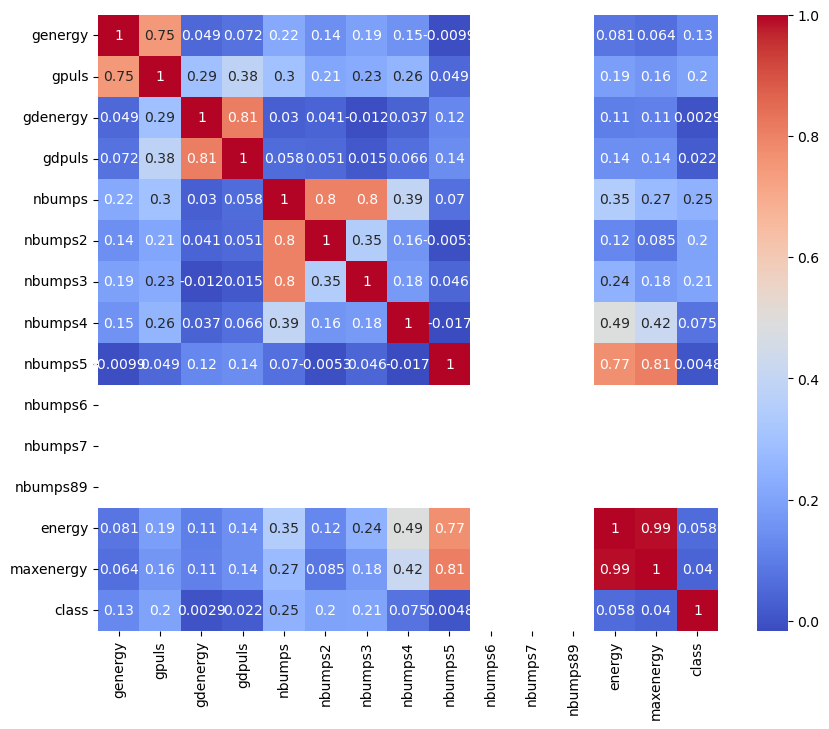

In [10]:
# Plot the correlation matrix for numerical features
corr = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

From the correlation matrix, among the features that highly correlated with each others include:
- `energy` and `maxenergy` (0.99)
- `gdpuls` and `gdenergy` (0.81)
- `nbumps5` and `maxenergy` (0.81)
- `nbumps` and `nbumps2` (0.8)
- `nbumps` and `nbumps3` (0.8)
- `nbumps5` and `energy` (0.77)
- `gpuls` and `genergy` (0.75)

Features that do not show any correlation with other classes:
- `nbumps6`
- `nbumps7`
- `nbumps89`

These features can be dropped in the subsequent steps as they do not need to be involved in the model training.

**None of the features** show direct correlation with the target column, `class`.

`class` column can be dropped from numerical DataFrame `numerical_df` as it is a target column

In [11]:
# Drop the features that are not needed for the analysis
df.drop(['nbumps89', 'nbumps7', 'nbumps6'], axis=1, inplace=True)
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0


In [12]:
# Drop the features that are not needed for the analysis and the target variable
numerical_df.drop(['nbumps89', 'nbumps7', 'nbumps6', 'class'], axis=1, inplace=True)
numerical_df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
0,15180,48,-72,-72,0,0,0,0,0,0,0
1,14720,33,-70,-79,1,0,1,0,0,2000,2000
2,8050,30,-81,-78,0,0,0,0,0,0,0
3,28820,171,-23,40,1,0,1,0,0,3000,3000
4,12640,57,-63,-52,0,0,0,0,0,0,0


In [13]:
# Summarize the numerical features
numerical_df.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
count,2.578000e+03,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000,2578.000000
mean,9.034118e+04,539.366563,12.392940,4.521334,0.861521,0.394492,0.393716,0.067882,0.004655,4986.850272,4288.809154
std,2.294339e+05,562.945864,80.352799,63.211324,1.365573,0.784454,0.770372,0.279364,0.068080,20473.216356,19378.874276
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.169250e+04,191.250000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.550000e+04,379.500000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.275750e+04,669.000000,38.000000,30.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2675.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,402000.000000,400000.000000


In [14]:
# Categorize the continuous features
continuous_df = numerical_df[["genergy", "gpuls", "gdenergy", "gdpuls", "energy", "maxenergy"]]
continuous_df.head()

,genergy,gpuls,gdenergy,gdpuls,energy,maxenergy
0,15180,48,-72,-72,0,0
1,14720,33,-70,-79,2000,2000
2,8050,30,-81,-78,0,0
3,28820,171,-23,40,3000,3000
4,12640,57,-63,-52,0,0


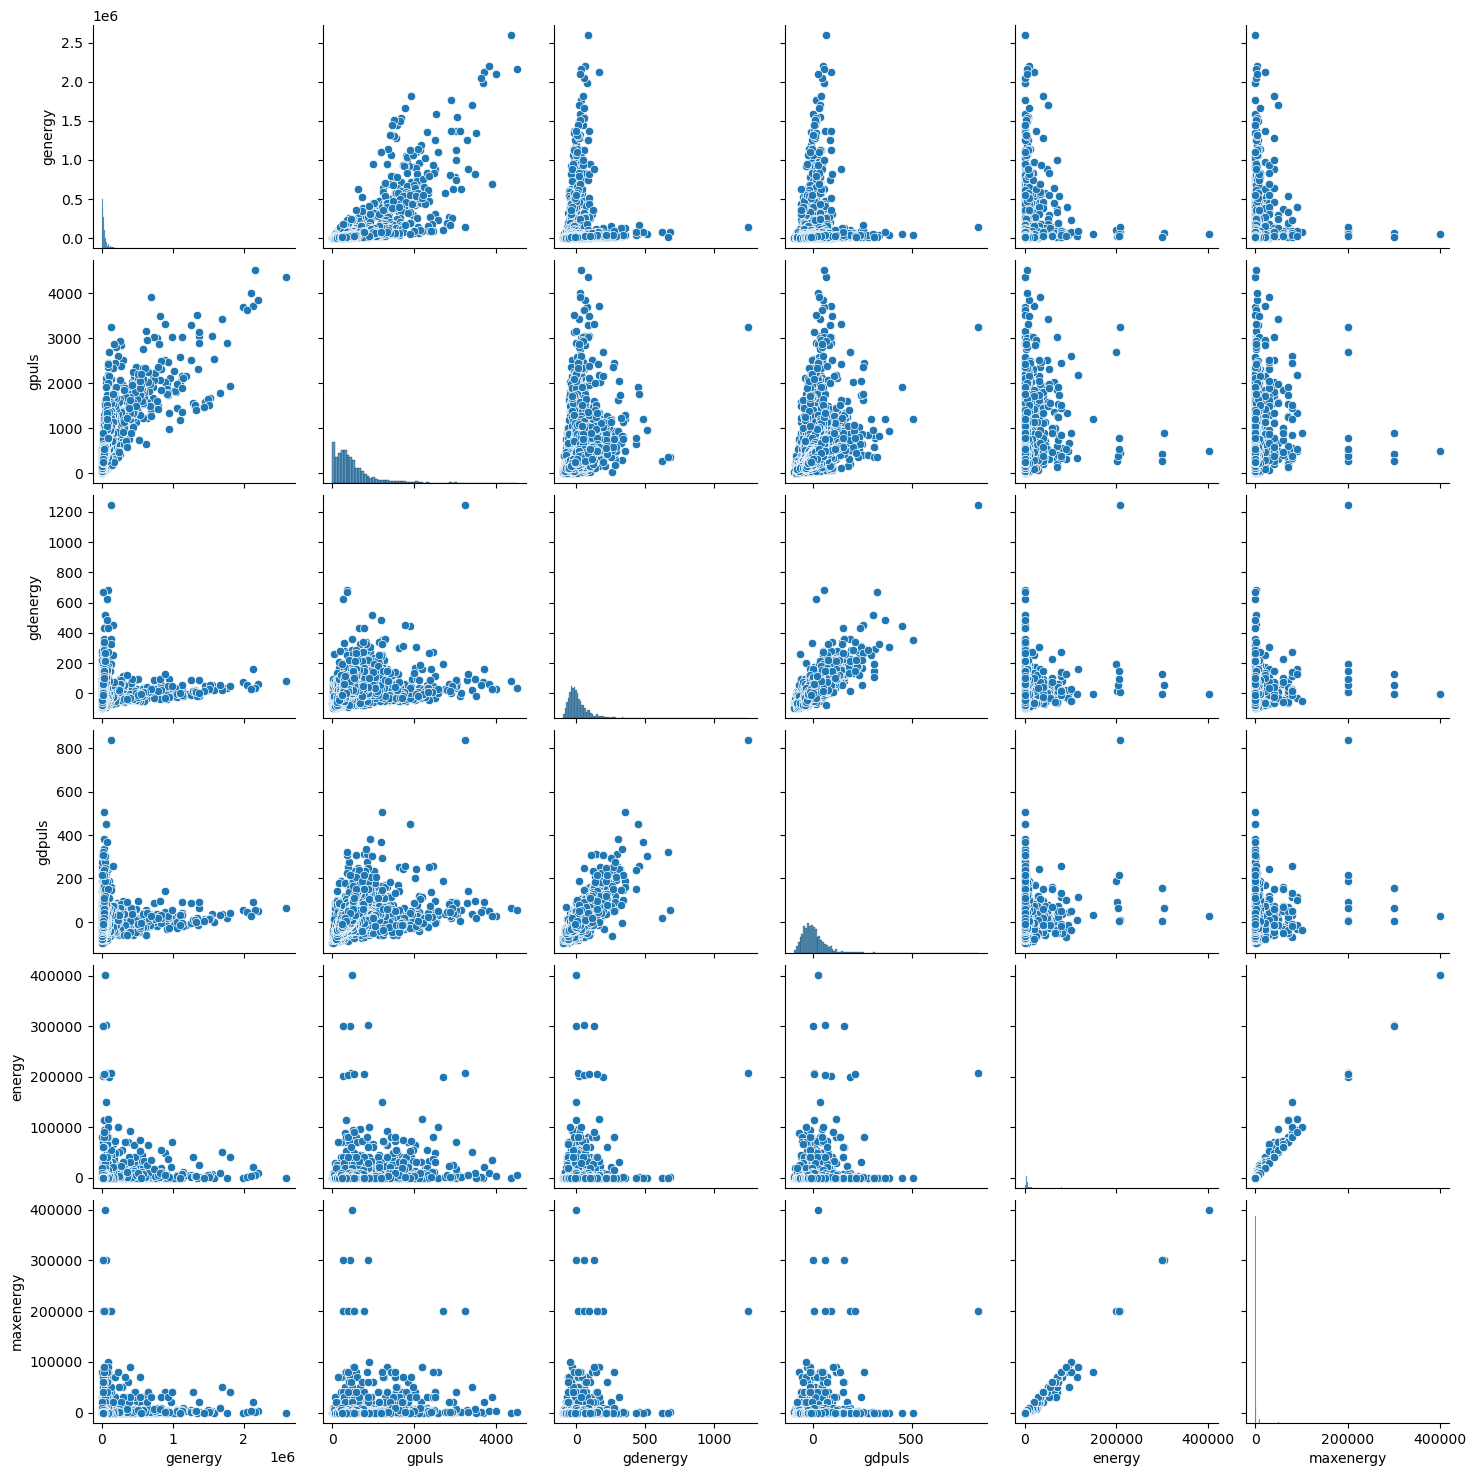

In [15]:
# Plot the distribution of continuous features
sns.pairplot(continuous_df, size = 2.5)
plt.show()

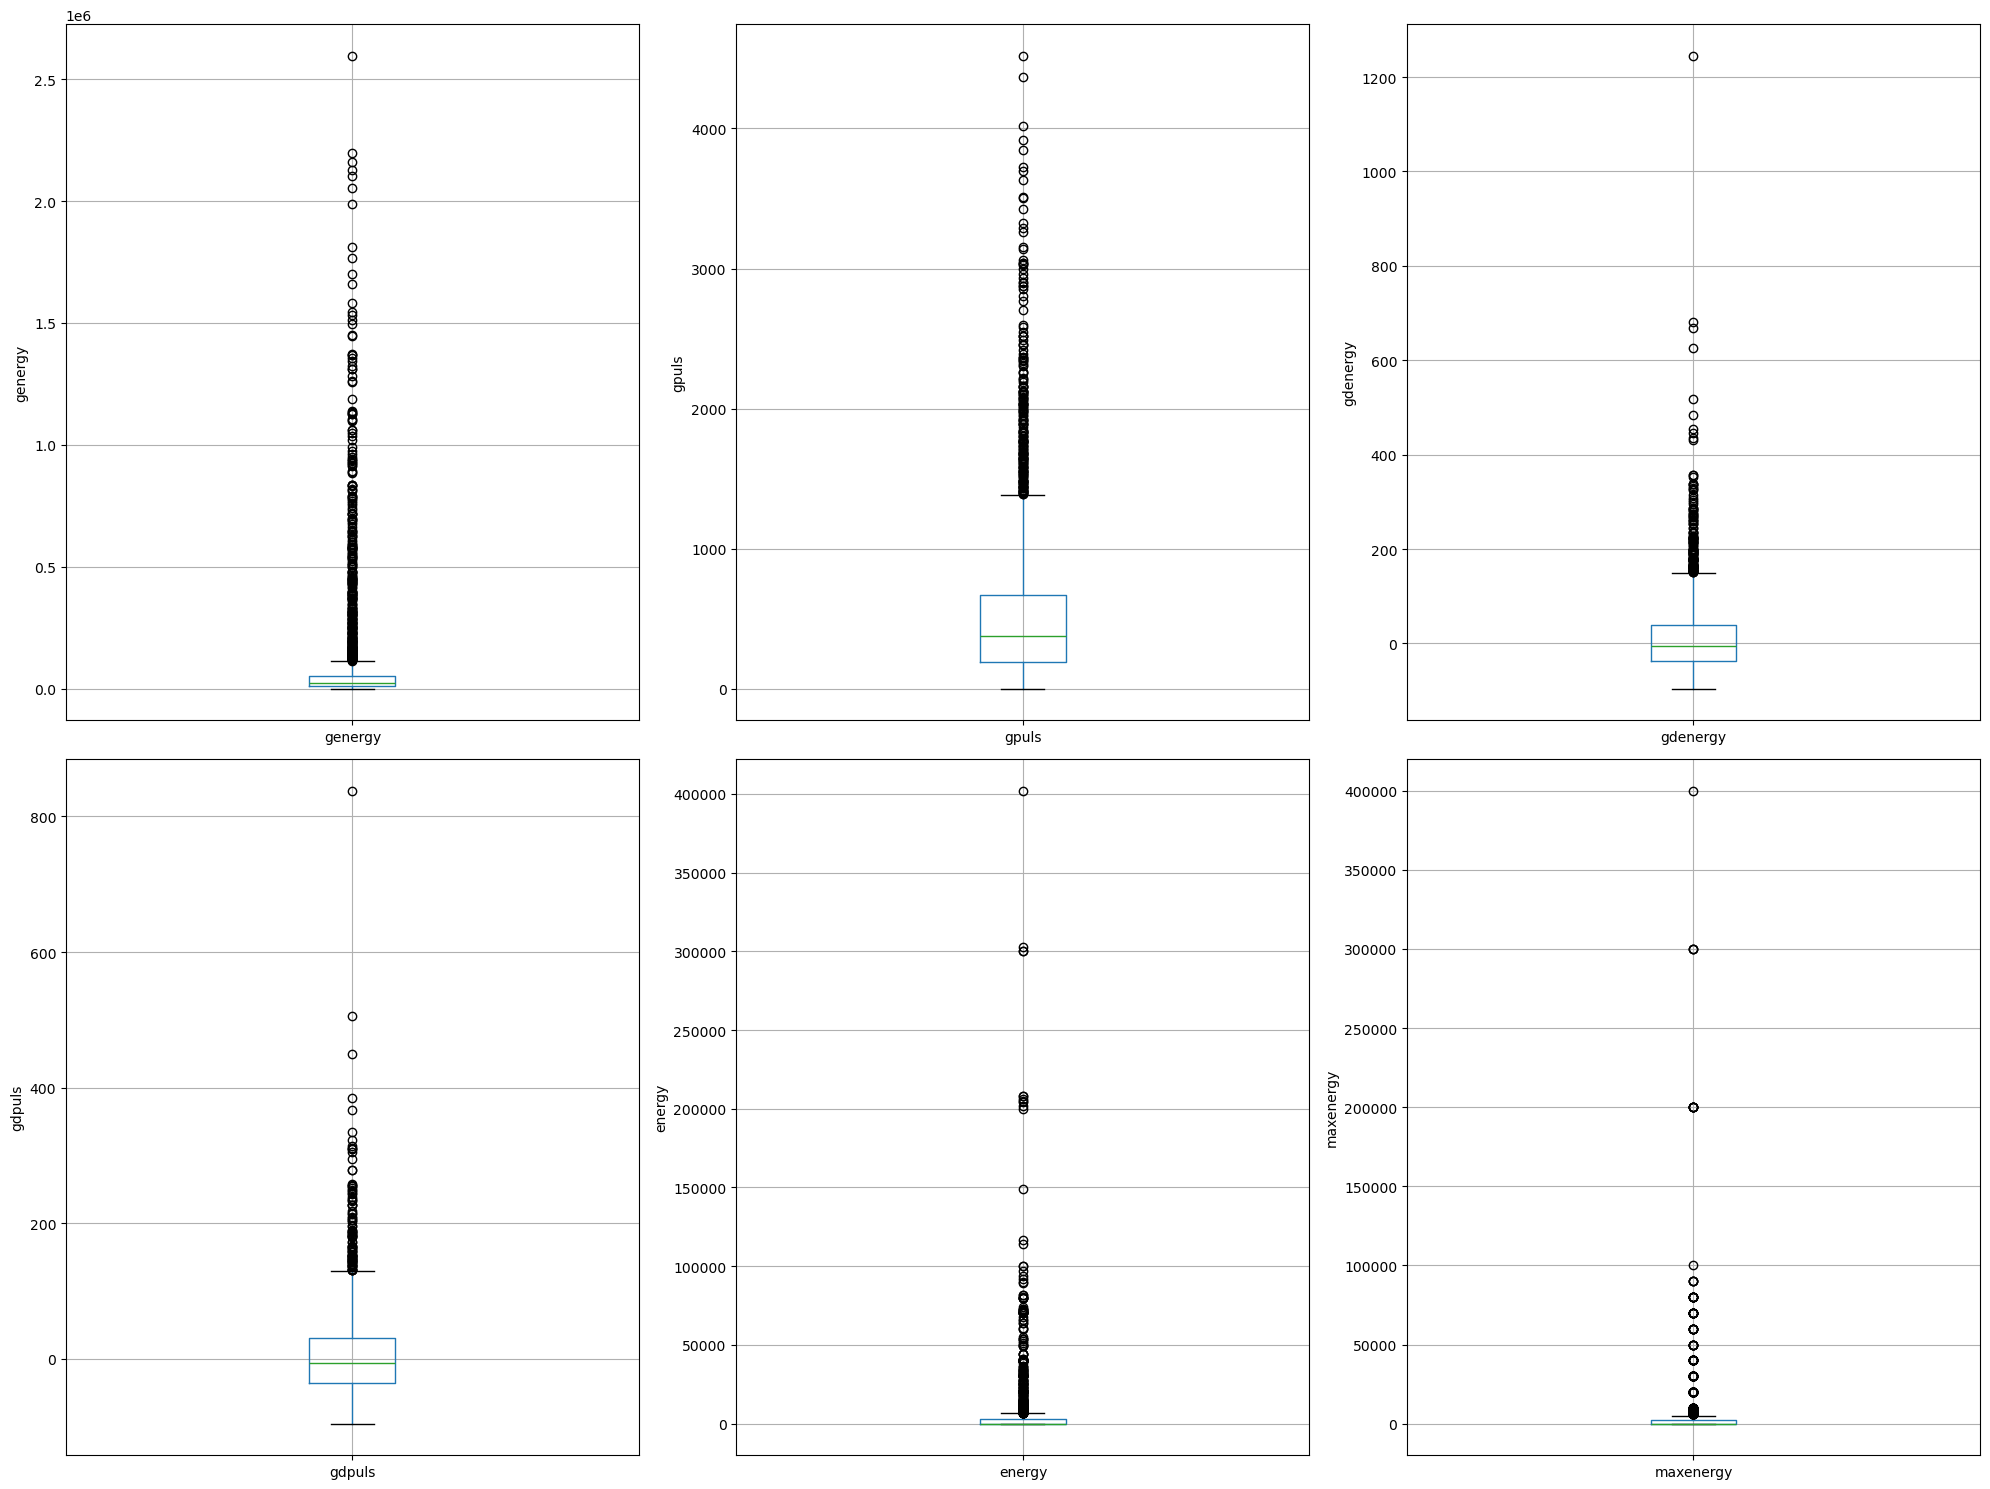

In [16]:
# Set the figure size
plt.figure(figsize=(20, 15))

# Loop through the columns and create subplots
for i, column in enumerate(continuous_df.columns, 1):
    plt.subplot(2, 3, i)  # Create a subplot in a 2x3 grid
    fig = df.boxplot(column=column)
    fig.set_title('')
    fig.set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# Check for the dimensions of the DataFrame after data cleaning
df.shape

(2578, 16)

In [18]:
# Save the cleaned DataFrame
X = df.drop(columns=label).values
y = df[label].values

# Show the shape of the data
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (2578, 15)
y shape:  (2578,)


#### Split the dataset
Split the dataset into training, validation and test sets.

In [19]:

# Split the dataset into training, validation, and test sets
# Training : Validation : Test = 7 : 1 : 2

seed_num = 42
np.random.seed(seed_num) # Set NumPy random seed
tf.random.set_seed(seed_num)  # Set TensorFlow random seed

# Split the dataset into training and test sets
# test_size = 0.2 as (training dataset + validation dataset) : test dataset = 8 : 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_num,
    # stratify=y
)

# Split the training dataset into training and validation sets
# test_size = 0.125 as training dataset : validation dataset = 7 : 1
X_train, X_vald, y_train, y_vald = train_test_split(
    X_train,
    y_train,
    test_size=0.125,
    random_state=seed_num,
    # stratify=y_train
)

# Show the shape of the datasets
print("Original dataset shape:")
print("X shape:", X.shape, ", y shape:", y.shape, "\n")

print("Training set shape:")
print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape, "\n")

print("Validation set shape:")
print("X_vald shape:", X_vald.shape, ", y_vald shape:", y_vald.shape, "\n")

print("Test set shape: ")
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)

Original dataset shape:
X shape: (2578, 15) , y shape: (2578,) 

Training set shape:
X_train shape: (1804, 15) , y_train shape: (1804,) 

Validation set shape:
X_vald shape: (258, 15) , y_vald shape: (258,) 

Test set shape: 
X_test shape: (516, 15) , y_test shape: (516,)


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description:

This section outlines a comprehensive data preprocessing pipeline designed to prepare the Seismic Bumps Dataset for a classification task aimed at predicting whether a high-energy seismic bump will occur in the next shift.

The process includes **label encoding and data scaling**: ordinal categorical features are transformed using `Label Encoding,` while nominal features are encoded with `One-Hot Encoding`. Numerical features are scaled using the `Robust Scaler` to reduce the impact of outliers and skewed distributions. To address class imbalance, the `SMOTE (Synthetic Minority Over-sampling Technique)` is applied exclusively to the training set.

##### Label encoding & data scaling

Based on the column description, DataFrame consists of

Categorical data includes
- Ordinal: `seismic`, `seismoacoustic`, and `ghazard`
- Nominal: `shift`

and numerical data.

The data are encoded based on their categories:
- Ordinal categorical values using **Label Encoding**,
- Nominal categorical values using **One Hot Encoding**,
- and Numerical values using **Robust Scaler**

**Robust Scaler** is used instead of **MinMaxScaler** as seismic data often includes extreme value (e.g. sudden energy spikes, zero-heavy counts). RoubstScaler is typically safer as it is good for data that has outliers or heavy skew.

In [20]:
# Convert X_train to a DataFrame for scaling
X_train_df = pd.DataFrame(X_train, columns=df.drop(columns=label).columns)
X_vald_df = pd.DataFrame(X_vald, columns=df.drop(columns=label).columns)
X_test_df = pd.DataFrame(X_test, columns=df.drop(columns=label).columns)

In [21]:
# Apply Label Encoding to the ordinal categorical columns
label_encoder = LabelEncoder()

for column in categorical_df.columns:
    if column != 'shift':
        # Transform the training, validation, and test sets
        X_train_df[column] = label_encoder.fit_transform(X_train_df[column])
        X_vald_df[column] = label_encoder.transform(X_vald_df[column])
        X_test_df[column] = label_encoder.transform(X_test_df[column])

In [22]:
# Apply One-Hot Encoding to the nominal categorical columns
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

def onehot_encode_and_concat(df, column, onehot_encoder): 
    onehot_encoded = onehot_encoder.transform(df[[column]])
    onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out([column]), index=df.index)
    df = df.drop(column, axis=1) # drop the original column
    return pd.concat([df, onehot_df], axis=1)

onehot_encoder.fit(X_train_df[['shift']])

# Transform the training, validation, and test sets
X_train_df = onehot_encode_and_concat(X_train_df, 'shift', onehot_encoder)
X_vald_df = onehot_encode_and_concat(X_vald_df, 'shift', onehot_encoder)
X_test_df = onehot_encode_and_concat(X_test_df, 'shift', onehot_encoder)

In [23]:
# Apply Robust Scaling to the numerical columns
numerical_scaler = RobustScaler()

# Transform the training, validation, and test sets
X_train_df[numerical_df.columns] = numerical_scaler.fit_transform(X_train_df[numerical_df.columns])
X_vald_df[numerical_df.columns] = numerical_scaler.transform(X_vald_df[numerical_df.columns])
X_test_df[numerical_df.columns] = numerical_scaler.transform(X_test_df[numerical_df.columns])

In [24]:
# Checkpoint the columns after encoding
columns_after_encoding = X_train_df.columns
columns_after_encoding

Index(['seismic', 'seismoacoustic', 'genergy', 'gpuls', 'gdenergy', 'gdpuls',
       'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5',
       'energy', 'maxenergy', 'shift_N', 'shift_W'],
      dtype='object')

In [25]:
# Display the scaled columns of the training set
X_train_df[numerical_df.columns].head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
0,-0.524304,-0.241362,-0.842105,-0.350365,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,-0.346626,-0.226921,-0.342105,0.014599,1.0,0.0,1.0,0.0,0.0,0.357143,0.5
2,0.655498,-0.559051,-0.118421,-0.029197,3.0,2.0,1.0,0.0,0.0,0.607143,0.5
3,-0.412931,-0.162971,-0.105263,0.598540,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,-0.272770,0.059825,0.697368,0.510949,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [26]:
# Display the scaled columns of the validation set
X_vald_df[numerical_df.columns].head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
0,0.411279,0.507478,0.710526,0.467153,1.0,1.0,0.0,0.0,0.0,0.107143,0.15
1,0.342850,1.949458,1.631579,2.452555,2.0,2.0,0.0,0.0,0.0,0.392857,0.30
2,3.318075,2.853017,0.144737,0.379562,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
3,-0.534686,-0.528107,-0.894737,-0.905109,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
4,0.543889,-0.631253,-0.618421,-0.656934,0.0,0.0,0.0,0.0,0.0,0.000000,0.00


In [27]:
# Display the scaled columns of the test set
X_test_df[numerical_df.columns].head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy
0,-0.592261,-0.767406,-1.039474,-1.109489,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,-0.328929,-0.101083,0.394737,0.802920,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.406796,-0.270242,0.368421,0.160584,3.0,0.0,3.0,0.0,0.0,1.428571,1.0
3,13.068429,4.051573,0.552632,0.686131,1.0,0.0,1.0,0.0,0.0,1.071429,1.5
4,-0.437471,-0.472408,-0.855263,-0.788321,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


##### Oversampling
**SMOTE (Synthetic Minority Over-sampling Technique)**, is used for oversampling the minority class in imbalanced datasets. It is only introduced to training dataset to prevent the unrealistic samples and data leakage in validation dataset and test dataset.

In [ ]:
# Oversampling
# SMOTE
smote = SMOTE(random_state=seed_num, sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train_df, y_train)

# Display the shape of the original and resampled datasets
print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_smote))

# Assign the oversampled data back to the training set
X_train = X_smote
y_train = y_smote

Original dataset shape: Counter({0: 1694, 1: 110})
Resample dataset shape: Counter({0: 1694, 1: 1694})


In [29]:
# Convert back to a NumPy array
X_vald = X_vald_df.values
X_test = X_test_df.values

#### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description:

To improve model efficiency and focus on the most informative attributes, **feature selection** was applied using `SelectKBest` with the `mutual_info_classif` scoring function. This technique evaluates each feature's relevance to the target variable by estimating the **mutual information**, a measure of how much knowing one variable reduces uncertainty about the other.

In [30]:
# Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_train = selector.fit_transform(X_train, y_train)

# Transform the validation and test sets using the same selector
X_vald = selector.transform(X_vald)
X_test = selector.transform(X_test)

# Get the feature names after encoding
selected_indices = selector.get_support(indices=True) # Get the indices of the selected features
selected_features = columns_after_encoding[selected_indices] # Get the names of the selected features
selected_features

Index(['gdenergy', 'gdpuls', 'nbumps', 'nbumps2', 'nbumps3', 'energy',
       'maxenergy', 'shift_N'],
      dtype='object')

The **top 8 most informative features** were selected from the training set, and the same transformation was applied to both the validation and test sets to ensure consistency. The resulting subset of features likely contributed the most to classification performance, helping reduce noise, overfitting risk, and computation time.

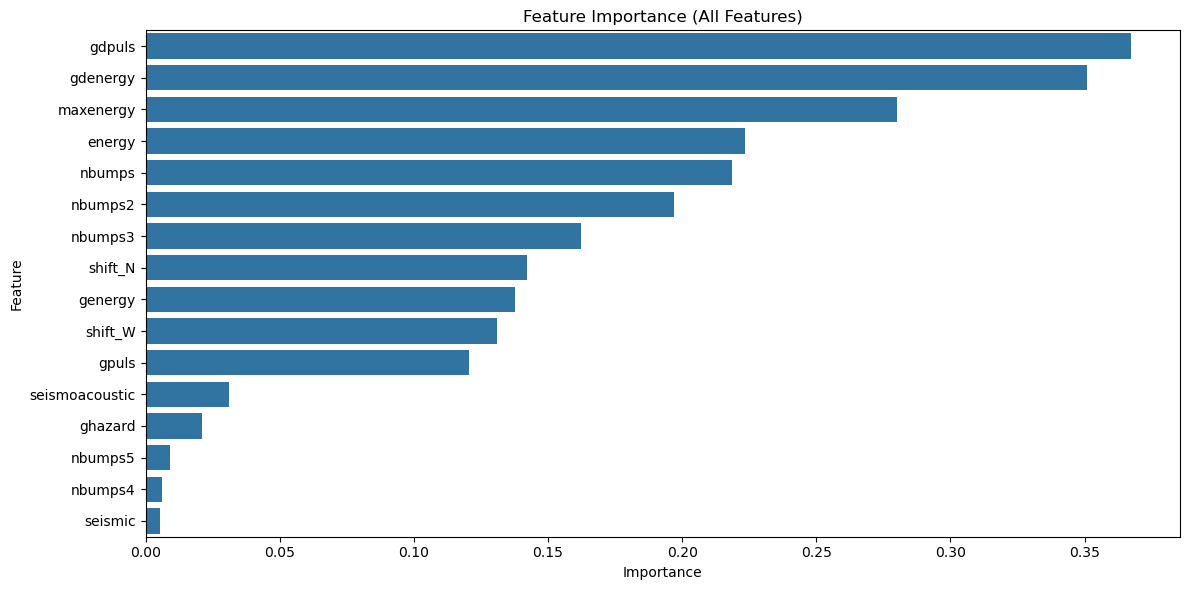

In [31]:
# Get all feature names BEFORE selection
all_feature_names = X_train_df.columns  # assuming x_train is a DataFrame

# Get all feature scores from the selector
all_scores = selector.scores_  # same length as original feature count

# Create a DataFrame of all features and their scores
feature_importances = pd.DataFrame({
    "feature": all_feature_names,
    "importance": all_scores
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Plot all features
plt.figure(figsize=(12, max(6, len(feature_importances) * 0.3)))  # dynamic height
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (All Features)")
plt.tight_layout()
plt.show()


To evaluate which features contributed most to the classification task, mutual information scores were computed for all input variables and visualized in a horizontal bar chart. The results show that the features `gdpuls`, `gdenergy`, and `maxenergy` had the highest mutual information with the target variable, indicating they contain the most predictive power for identifying high-energy seismic bumps. Other strong contributors include `energy`, `nbumps`, and its related variants like `nbumps2` and `nbumps3`, which capture localized bump activity. In contrast, features like `seismoacoustic`, `ghazard`, and `seismic` had very low mutual information scores and were likely excluded during feature selection. By focusing on the top 8 features identified in this analysis, the model reduces dimensionality and computational cost while retaining the most influential signals for learning.

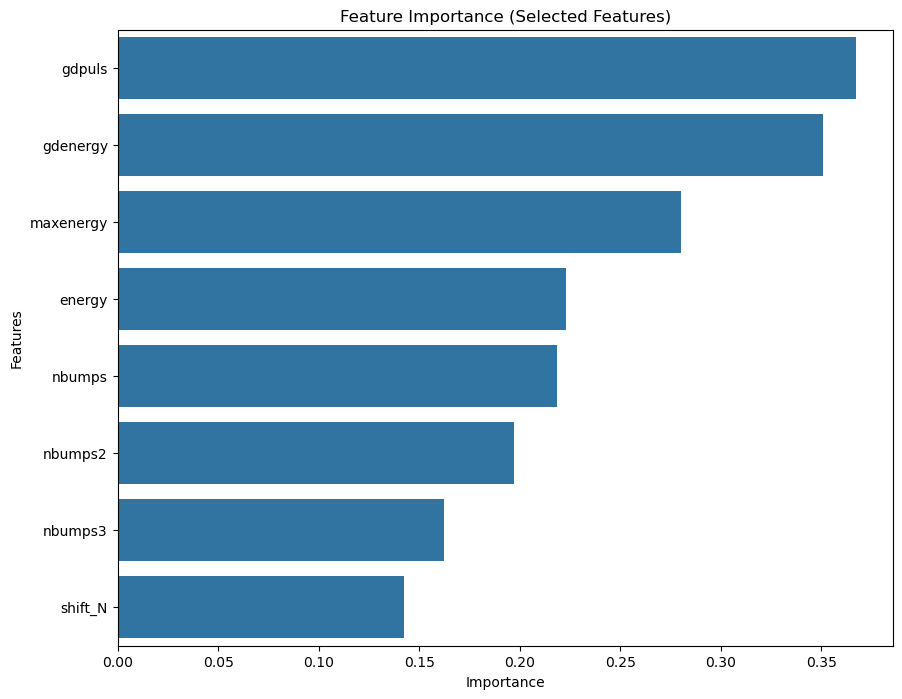

In [32]:
# Get the feature importances
# Get the indices of the selected features
importances = selector.scores_[selected_indices] # Get the scores of the selected features
feature_importances = pd.DataFrame({"feature": selected_features, "importance": importances}) # Create a DataFrame with feature names and their importances
feature_importances = feature_importances.sort_values("importance", ascending=False) # Sort the DataFrame by importance

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['importance'], y=feature_importances['feature'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Selected Features)')
plt.show()

The feature importance chart for the selected subset visualizes the top 8 features retained after applying `SelectKBest` with `mutual_info_classif`. Among these, `gdpuls`, `gdenergy`, and `maxenergy` stand out with the highest mutual information scores, suggesting they have the strongest predictive relationships with the target variable. These features likely capture significant seismic signal behavior relevant to high-energy bump events. Other features like `energy`, `nbumps`, and `nbumps2` also contribute notably, reflecting the model’s reliance on both signal intensity and historical bump counts. Although `nbumps3` and `shift_N` are lower on the list, their inclusion still adds meaningful diversity to the input space. Overall, this targeted selection improves model interpretability, reduces overfitting risk, and maintains predictive strength by focusing on the most informative attributes.

In [33]:
# Store the selected features back into the training set
X_train_df = pd.DataFrame(X_train, columns=selected_features)
X_train_df.head()

,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,energy,maxenergy,shift_N
0,-0.842105,-0.350365,0.0,0.0,0.0,0.000000,0.0,1.0
1,-0.342105,0.014599,1.0,0.0,1.0,0.357143,0.5,0.0
2,-0.118421,-0.029197,3.0,2.0,1.0,0.607143,0.5,1.0
3,-0.105263,0.598540,0.0,0.0,0.0,0.000000,0.0,1.0
4,0.697368,0.510949,0.0,0.0,0.0,0.000000,0.0,1.0


In [34]:
# Store the selected features back into the validation set
X_vald_df = pd.DataFrame(X_vald, columns=selected_features)
X_vald_df.head()

,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,energy,maxenergy,shift_N
0,0.710526,0.467153,1.0,1.0,0.0,0.107143,0.15,0.0
1,1.631579,2.452555,2.0,2.0,0.0,0.392857,0.30,0.0
2,0.144737,0.379562,0.0,0.0,0.0,0.000000,0.00,0.0
3,-0.894737,-0.905109,0.0,0.0,0.0,0.000000,0.00,1.0
4,-0.618421,-0.656934,0.0,0.0,0.0,0.000000,0.00,1.0


In [35]:
# Store the selected features back into the test set
X_test_df = pd.DataFrame(X_test, columns=selected_features)
X_test_df.head()

,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,energy,maxenergy,shift_N
0,-1.039474,-1.109489,0.0,0.0,0.0,0.000000,0.0,1.0
1,0.394737,0.802920,0.0,0.0,0.0,0.000000,0.0,1.0
2,0.368421,0.160584,3.0,0.0,3.0,1.428571,1.0,0.0
3,0.552632,0.686131,1.0,0.0,1.0,1.071429,1.5,0.0
4,-0.855263,-0.788321,0.0,0.0,0.0,0.000000,0.0,0.0


In [36]:
# Convert back to a NumPy array
X_train = X_train_df.values
X_vald = X_vald_df.values
X_test = X_test_df.values

In [37]:
# Check the shape of the datasets after oversampling
print("Training set shape:")
print("X_train shape:", X_train.shape, ", y_train shape:", y_train.shape)
print("X_train_df shape:", X_train_df.shape, ", y_train shape:", y_train.shape, "\n")

print("Validation set shape:")
print("X_vald shape:", X_vald.shape, ", y_vald shape:", y_vald.shape)
print("X_vald_df shape:", X_vald_df.shape, ", y_vald shape:", y_vald.shape, "\n")

print("Test set shape: ")
print("X_test shape:", X_test.shape, ", y_test shape:", y_test.shape)
print("X_test_df shape:", X_test_df.shape, ", y_test shape:", y_test.shape)

Training set shape:
X_train shape: (3388, 8) , y_train shape: (3388,)
X_train_df shape: (3388, 8) , y_train shape: (3388,) 

Validation set shape:
X_vald shape: (258, 8) , y_vald shape: (258,)
X_vald_df shape: (258, 8) , y_vald shape: (258,) 

Test set shape: 
X_test shape: (516, 8) , y_test shape: (516,)
X_test_df shape: (516, 8) , y_test shape: (516,)


#### Data modeling
You are tasked to build two (2) predictive models to predict the target variable of the dataset. One of the predictive models must be either Neural Network or Fuzzy Logic System. Perform a comparison between the two predictive models.
______________________________________________________________________________________
In this project, two predictive models were explored to model and predict the occurrence of high-energy seismic bumps which are **Decision Tree Classifier (DTC)**, and **Neural Network (NN)**. These models were chosen for their complementary strengths in handling non-linearity, interpretability, and flexible pattern recognition. **DTC** offers high interpretability and handles both linear and non-linear patterns by recursively splitting data based on features that maximize information gain, using criteria such as **Gini** or **Entropy**.

Given the imbalanced nature of the dataset, techniques like **SMOTE** were used to improve class balance before training. **NN** was included for its ability to model complex, non-linear relationshjips through multiple layers and activations, making it well-suited for capturing intricate patterns in the data.

Each model was tuned using cross-validation and evaluated using metrics like **accuracy**, **precision**, **recall**, and **F1-score**, with a strong focus on **recall** to reduce the risk of false negatives in this safety-critical domain.

##### Variables & Functions

In [38]:
# Repeated Stratified K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed_num)

In [39]:
def plot_confusion_matrices_side_by_side(y_true, y_pred_default, y_pred_optimized, model_name):
    """
    Plot confusion matrices for two models side by side
    """
    cm_default = confusion_matrix(y_true, y_pred_default)
    cm_optimized = confusion_matrix(y_true, y_pred_optimized)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Default model
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Default {model_name}')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Optimized model
    sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Optimized {model_name}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [40]:
def evaluate_validation_set(y_true, y_pred):
    """
    Evaluate the validation set using various metrics and print the results.
    
    Parameters:
    y_true (array-like): True labels of the validation set.
    y_pred (array-like): Predicted labels of the validation set.
    """
    print("\n")
    print("📊 Evaluation metrics for validation set:")
    print(f"Validation set accuracy: {accuracy_score(y_true, y_pred):.6f}")
    print(f"Validation set precision: {precision_score(y_true, y_pred):.6f}")
    print(f"Validation set recall: {recall_score(y_true, y_pred):.6f}")
    print(f"Validation set f1 score: {f1_score(y_true, y_pred):.6f}")
    print("\nValidation set confusion matrix: \n", confusion_matrix(y_true, y_pred))

    # Print the classification report for the validation set
    print("\nValidation set classification report: \n", classification_report(y_vald, y_pred))

In [41]:
def plot_roc_curve(y_true, model, model_short_name):
    """
    Plot ROC curve for a model.
    
    Parameters:
    y_true (array-like): True labels of the validation set.
    model (object): Trained model.
    model_short_name (str): Short name of the model for labeling the plot.
    """
    
    # Get probability predictions for class 1
    y_proba = model.predict_proba(X_vald)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - Optimized {model_short_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [42]:
def plot_model_comparison(y_vald, y_pred_default, y_pred_optimized, model_name, model_short_name):
    """
    Plot the model comparison for the validation set
    """
    # Prepare data for the bar graph
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    default_scores = [
        accuracy_score(y_vald, y_pred_default),
        precision_score(y_vald, y_pred_default),
        recall_score(y_vald, y_pred_default),
        f1_score(y_vald, y_pred_default)
    ]
    optimized_scores = [
        accuracy_score(y_vald, y_pred_optimized),
        precision_score(y_vald, y_pred_optimized),
        recall_score(y_vald, y_pred_optimized),
        f1_score(y_vald, y_pred_optimized)
    ]

    # Plot the bar graph
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, default_scores, width, label='Default ' + model_short_name)
    bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized ' + model_short_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison of Default and Optimized ' + model_name)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Annotate bars with their values
    for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.6f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.6f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

##### Decision Tree Classifier (DTC)

The **Decision Tree Classifier (DTC)** is a supervised learning algorithm used for classification tasks. It splits the dataset into branches based on feature values, creating a tree structure where each leaf represents a class label. The algorithm selects splits that maximize information gain or minimize impurity (e.g., Gini or entropy).

In this project, the DTC is applied to predict whether a high-energy seismic bump will occur (`class` = 1) based on features like seismic energy (`genergy`), number of seismic bumps (`nbumps`), and others. The dataset is imbalanced, so techniques like SMOTE are used to balance the training data.

The DTC is evaluated using metrics such as accuracy, precision, recall, and F1-score, with a focus on recall to minimize false negatives. Hyperparameter tuning (e.g., `max_depth`, `min_samples_split`) is performed to optimize the model. The tree's interpretability and ability to handle non-linear relationships make it suitable for this task.

An instance of DTC with default parameters

In [43]:
# Initialize the Decision Tree Classifier
dtc_default_model = DecisionTreeClassifier(random_state=seed_num)

# Fit the Decision Tree Classifier on the training set
dtc_default_model.fit(X_train, y_train)

# Make predictions on the validation set
y_dtc_default_pred_val = dtc_default_model.predict(X_vald)

# Print the default parameters of the Decision Tree Classifier
print("Default parameters of Decision Tree Classifier: \n", dtc_default_model.get_params())

# Print the evaluation metrics for the validation set
evaluate_validation_set(y_vald, y_dtc_default_pred_val)

Default parameters of Decision Tree Classifier: 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


📊 Evaluation metrics for validation set:
Validation set accuracy: 0.844961
Validation set precision: 0.133333
Validation set recall: 0.222222
Validation set f1 score: 0.166667

Validation set confusion matrix: 
 [[214  26]
 [ 14   4]]

Validation set classification report: 
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       240
           1       0.13      0.22      0.17        18

    accuracy                           0.84       258
   macro avg       0.54      0.56      0.54       258
weighted avg       0.88      0.84      0.86       258



The Decision Tree Classifier (DTC) was trained with default parameters and evaluated on the validation set. The results showed moderate accuracy and recall, with the model effectively identifying the majority class but struggling with the minority class (`class = 1`).

The confusion matrix highlighted a significant number of false negatives, indicating the model's limited sensitivity to high-energy seismic bumps. While the default DTC provides a baseline, its performance suggests the need for hyperparameter tuning to improve recall and better handle the imbalanced dataset.

Hyperparameter tuning using GridSearchCV for DTC

In [ ]:
# Set the hyperparameter grid for the Decision Tree Classifier
dtc_param_grid = {
    'ccp_alpha': [0.0, 0.0005, 0.001], # Complexity parameter for pruning
    'class_weight': ['balanced'], # Use balanced class weights
    'criterion': ['gini', 'entropy'], # Splitter criterion
    'max_depth': [5, 7, 9, 11, 13], # Maximum depth of the tree
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None], # Maximum number of leaf nodes
    'min_impurity_decrease': [0.0, 0.001, 0.01], # Minimum impurity decrease required to split a node
    'min_samples_leaf': [1, 2, 4, 6], # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 4, 6], # Minimum number of samples required to split an internal node
    'splitter': ['best'], # Best splitter strategy choosen instead of random
}

# Initialize the base Decision Tree
dtc = DecisionTreeClassifier(random_state=seed_num)

# Set up GridSearchCV
dtc_grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=dtc_param_grid,
    scoring="recall", # Choose to refit the base model based on recall score due to class imbalance
    cv=cv, # 5-fold cross-validation with 3 repeats 
    verbose=2, # Verbose output 2 to see the progress in detail
    n_jobs=-1, # Use all available cores to speed up the process
    error_score=0, # Set error score to 0 for any failed configurations
)

# Fit the grid search to training data
dtc_grid_results = dtc_grid_search.fit(X_train, y_train)

# Output best hyperparameters and best cross-validation score
print(f"✅ Best hyperparameters found: {dtc_grid_results.best_params_}")
print(f"✅ Best cross-validation score: {dtc_grid_results.best_score_:.6f}")

# Get the best model
dtc_best_model = dtc_grid_results.best_estimator_

# Make predictions on the validation set
y_dtc_best_pred_val = dtc_best_model.predict(X_vald)

# Print the evaluation metrics for the validation set
evaluate_validation_set(y_vald, y_dtc_best_pred_val)


Fitting 25 folds for each of 2160 candidates, totalling 54000 fits
✅ Best hyperparameters found: {'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
✅ Best cross-validation score: 0.846870


📊 Evaluation metrics for validation set:
Validation set accuracy: 0.872093
Validation set precision: 0.200000
Validation set recall: 0.277778
Validation set f1 score: 0.232558

Validation set confusion matrix: 
 [[220  20]
 [ 13   5]]

Validation set classification report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       240
           1       0.20      0.28      0.23        18

    accuracy                           0.87       258
   macro avg       0.57      0.60      0.58       258
weighted avg       0.89      0.87      0.88       258



The Decision Tree Classifier (DTC) underwent hyperparameter tuning using GridSearchCV to optimize recall, a critical metric for detecting high-energy seismic bumps. The best model achieved improved recall by adjusting parameters such as `max_depth`, `min_samples_split`, and `criterion`. Evaluation on the validation set showed a reduction in false negatives compared to the default model, demonstrating the effectiveness of tuning in handling the imbalanced dataset.

In [45]:
# Convert the results of the GridSearchCV into a DataFrame
# Sort the DataFrame by the mean test score in descending order
# Display the top 10 configurations with the highest mean test scores
results_dtc_df = pd.DataFrame(dtc_grid_search.cv_results_)
results_dtc_df.sort_values(
    by=['rank_test_score', 'mean_test_score'], 
    ascending=[True, False]
).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,...,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,mean_test_score,std_test_score,rank_test_score
1011,0.004344,0.000560,0.001441,0.000517,0.0005,balanced,gini,13,sqrt,None,...,0.795858,0.899705,0.787611,0.843658,0.861357,0.863905,0.908555,0.846870,0.038190,1
1012,0.004284,0.000650,0.001741,0.000551,0.0005,balanced,gini,13,sqrt,None,...,0.795858,0.899705,0.787611,0.843658,0.861357,0.863905,0.908555,0.846870,0.038190,1
291,0.005064,0.001143,0.001786,0.000667,0.0000,balanced,gini,13,sqrt,None,...,0.786982,0.902655,0.793510,0.840708,0.849558,0.863905,0.917404,0.843087,0.043263,3
292,0.004631,0.001059,0.001501,0.000584,0.0000,balanced,gini,13,sqrt,None,...,0.786982,0.902655,0.793510,0.840708,0.849558,0.863905,0.917404,0.843087,0.043263,3
288,0.005275,0.002585,0.001741,0.000567,0.0000,balanced,gini,13,sqrt,None,...,0.810651,0.849558,0.817109,0.805310,0.825959,0.872781,0.899705,0.842388,0.036593,5
1008,0.004404,0.000548,0.001493,0.000621,0.0005,balanced,gini,13,sqrt,None,...,0.807692,0.840708,0.817109,0.811209,0.811209,0.863905,0.896755,0.835066,0.040488,6
289,0.004384,0.000620,0.001642,0.000502,0.0000,balanced,gini,13,sqrt,None,...,0.748521,0.867257,0.790560,0.831858,0.796460,0.781065,0.887906,0.834701,0.046108,7
324,0.005184,0.000631,0.001662,0.000485,0.0000,balanced,gini,13,log2,None,...,0.822485,0.890855,0.793510,0.784661,0.852507,0.926036,0.902655,0.833069,0.048831,8
1731,0.004644,0.000673,0.001662,0.000810,0.0010,balanced,gini,13,sqrt,None,...,0.792899,0.876106,0.764012,0.828909,0.905605,0.869822,0.911504,0.832948,0.046789,9
1732,0.004763,0.000940,0.002722,0.004823,0.0010,balanced,gini,13,sqrt,None,...,0.792899,0.876106,0.764012,0.828909,0.905605,0.869822,0.911504,0.832948,0.046789,9


In [46]:
results_dtc_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(
    by=['rank_test_score', 'mean_test_score'],
    ascending=[True, False]
).head(10)

,params,mean_test_score,rank_test_score
1011,"{'ccp_alpha': 0.0005, 'class_weight': 'balance...",0.846870,1
1012,"{'ccp_alpha': 0.0005, 'class_weight': 'balance...",0.846870,1
291,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.843087,3
292,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.843087,3
288,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.842388,5
1008,"{'ccp_alpha': 0.0005, 'class_weight': 'balance...",0.835066,6
289,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.834701,7
324,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.833069,8
1731,"{'ccp_alpha': 0.001, 'class_weight': 'balanced...",0.832948,9
1732,"{'ccp_alpha': 0.001, 'class_weight': 'balanced...",0.832948,9


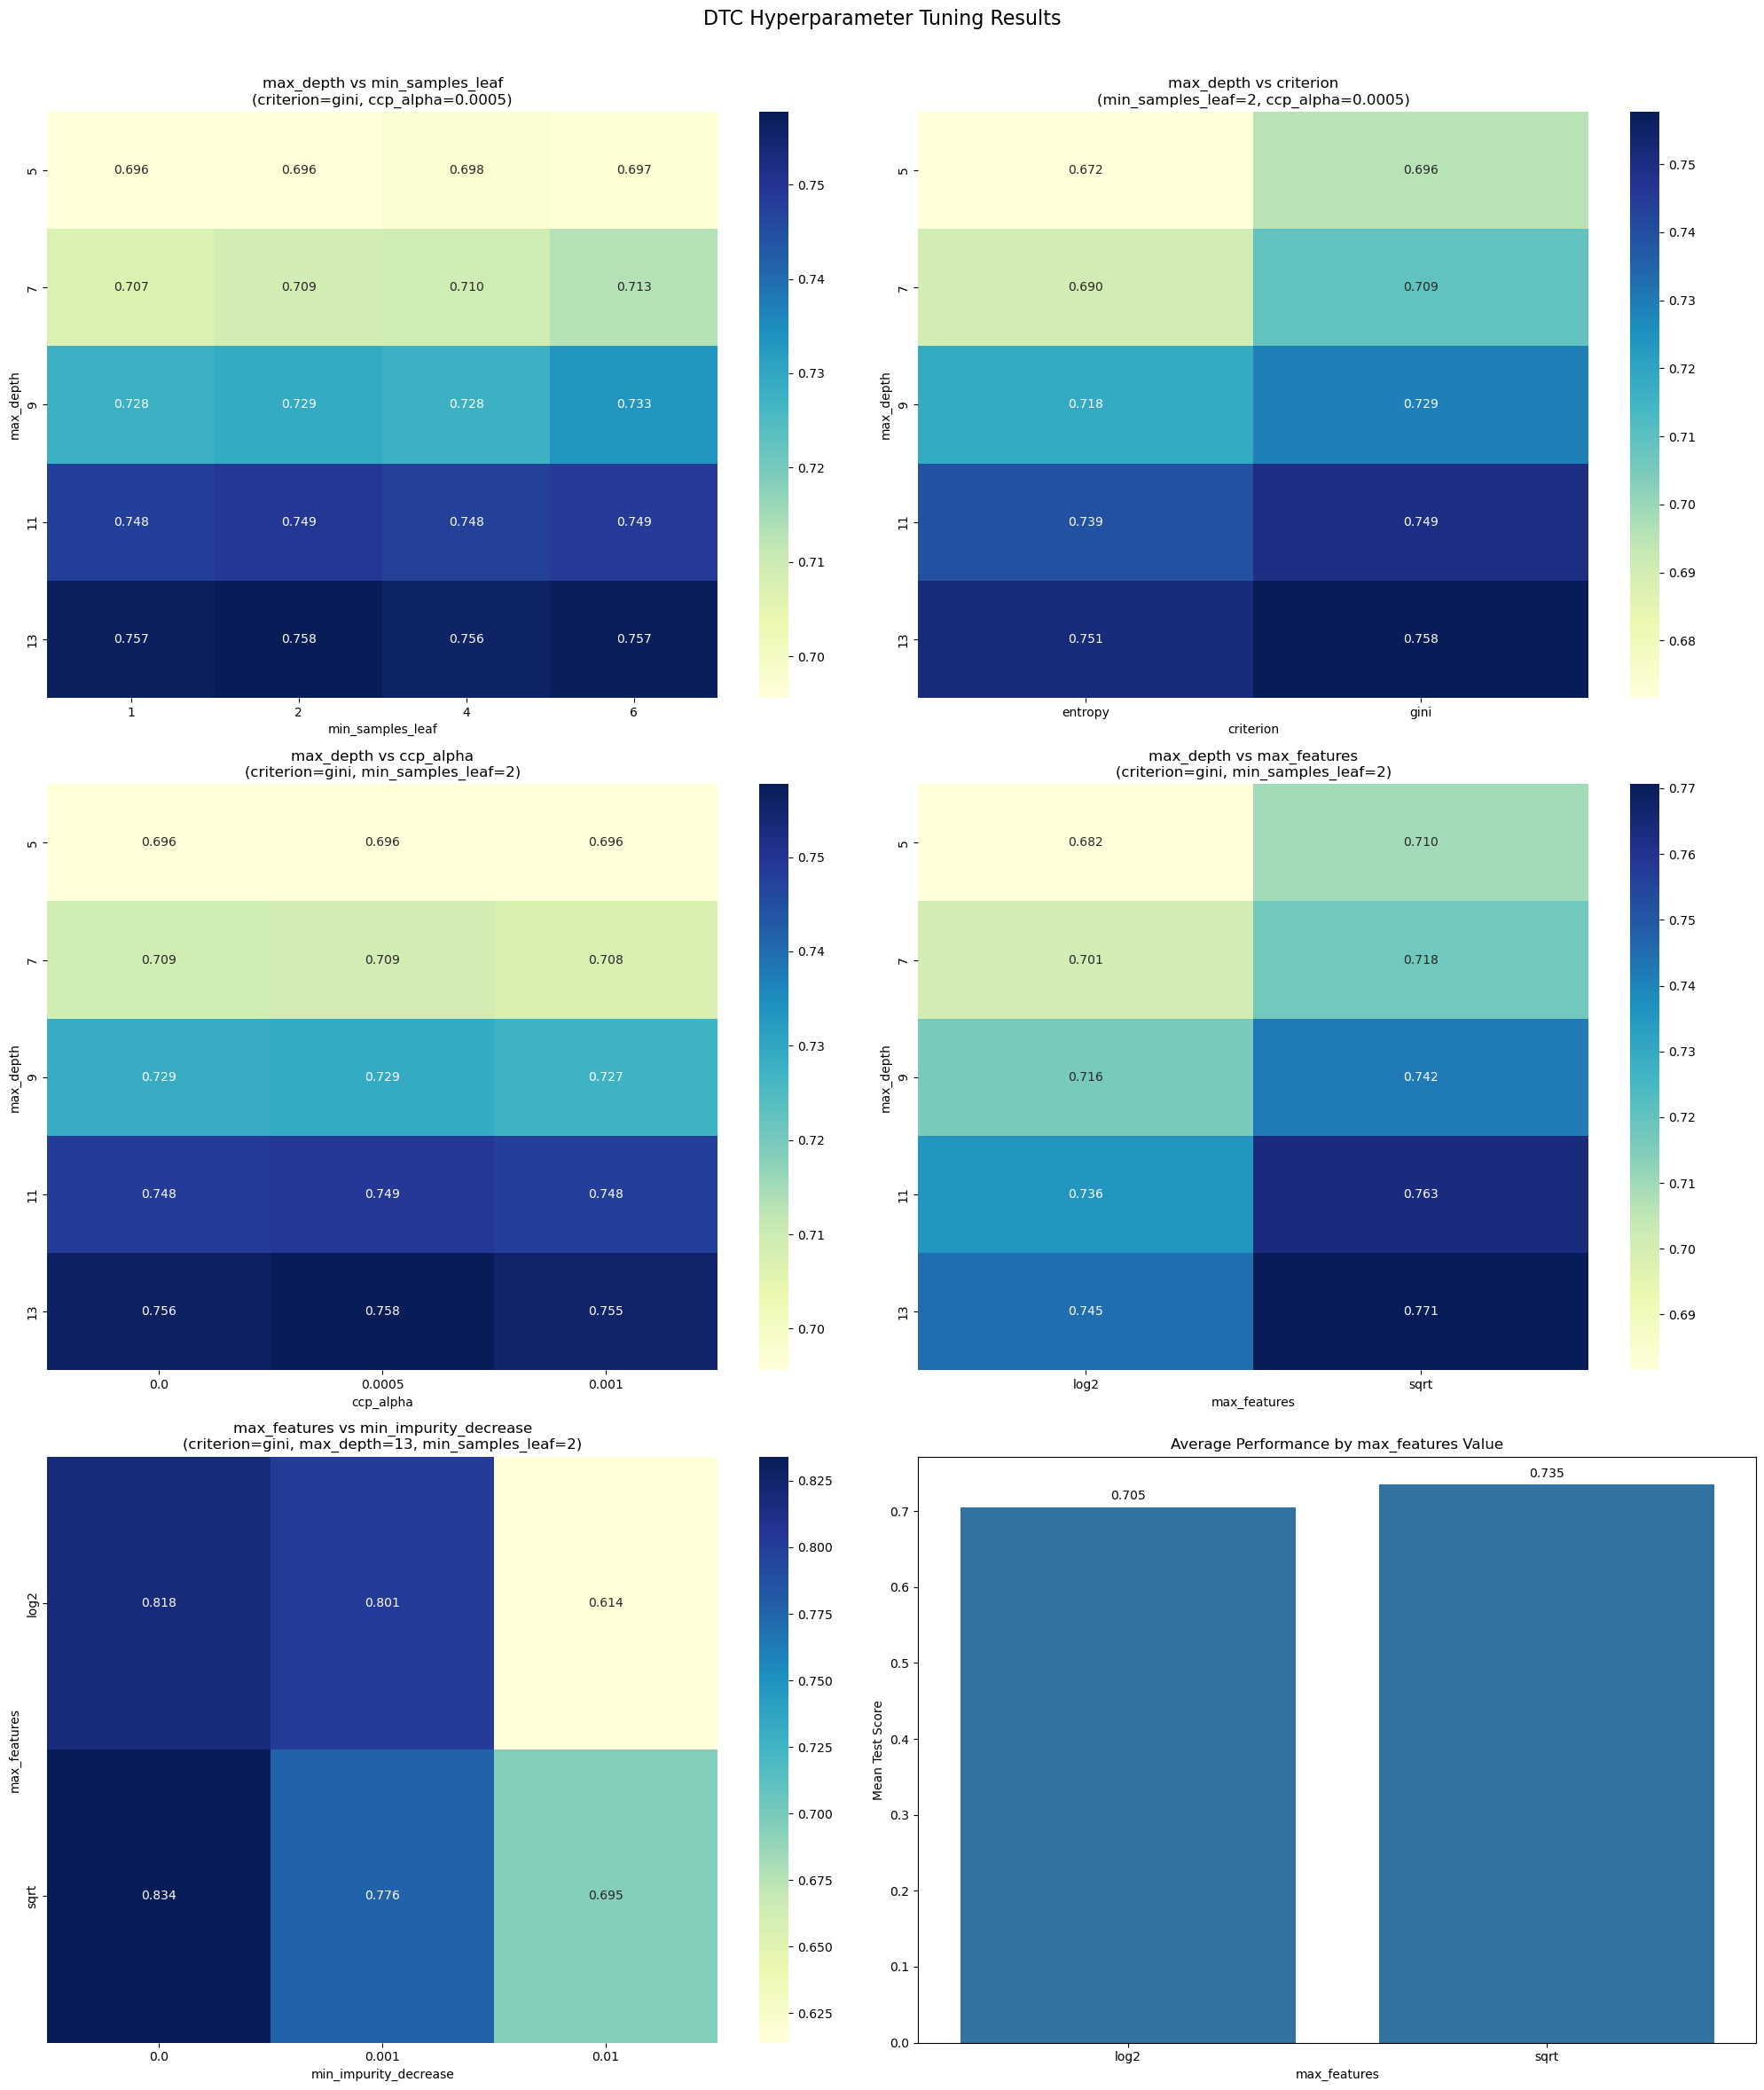

In [47]:
# Create a comprehensive visualization with multiple heatmaps of DTC hyperparameters tuning results
results_dtc_df = pd.DataFrame(dtc_grid_search.cv_results_)

# Set up a 3x2 grid of subplots to include all visualizations
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
fig.suptitle('DTC Hyperparameter Tuning Results', fontsize=16)

# Function to safely create a heatmap, handling empty dataframes
def safe_heatmap(filtered_df, x_param, y_param, ax, title):
    if filtered_df.empty:
        ax.text(0.5, 0.5, f"No data for\n{title}", 
                ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
    
    pivot = filtered_df.pivot_table(
        values='mean_test_score',
        index=f'param_{y_param}',
        columns=f'param_{x_param}'
    )
    
    if pivot.empty or pivot.size == 0:
        ax.text(0.5, 0.5, f"No data for\n{title}", 
                ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
        
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='YlGnBu', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_param)
    ax.set_ylabel(y_param)

# 1. max_depth vs min_samples_leaf
df_filtered1 = results_dtc_df[
    (results_dtc_df['param_criterion'] == 'gini') &
    (results_dtc_df['param_ccp_alpha'] == 0.0005)
]
safe_heatmap(
    df_filtered1, 
    'min_samples_leaf', 
    'max_depth', 
    axes[0, 0], 
    'max_depth vs min_samples_leaf\n(criterion=gini, ccp_alpha=0.0005)'
)

# 2. max_depth vs criterion
df_filtered2 = results_dtc_df[
    (results_dtc_df['param_min_samples_leaf'] == 2) &
    (results_dtc_df['param_ccp_alpha'] == 0.0005)
]
safe_heatmap(
    df_filtered2, 
    'criterion', 
    'max_depth', 
    axes[0, 1], 
    'max_depth vs criterion\n(min_samples_leaf=2, ccp_alpha=0.0005)'
)

# 3. max_depth vs ccp_alpha
df_filtered3 = results_dtc_df[
    (results_dtc_df['param_criterion'] == 'gini') &
    (results_dtc_df['param_min_samples_leaf'] == 2)
]
safe_heatmap(
    df_filtered3, 
    'ccp_alpha', 
    'max_depth', 
    axes[1, 0], 
    'max_depth vs ccp_alpha\n(criterion=gini, min_samples_leaf=2)'
)

# 4. max_depth vs max_features
df_filtered4 = results_dtc_df[
    (results_dtc_df['param_criterion'] == 'gini') &
    (results_dtc_df['param_min_samples_leaf'] == 2) &
    (results_dtc_df['param_ccp_alpha'] == 0.0005)
]
safe_heatmap(
    df_filtered4, 
    'max_features', 
    'max_depth', 
    axes[1, 1], 
    'max_depth vs max_features\n(criterion=gini, min_samples_leaf=2)'
)

# 5. max_features vs min_impurity_decrease heatmap
df_filtered5 = results_dtc_df[
    (results_dtc_df['param_criterion'] == 'gini') &
    (results_dtc_df['param_max_depth'] == 13) &
    (results_dtc_df['param_min_samples_leaf'] == 2)
]

if not df_filtered5.empty:
    pivot5 = df_filtered5.pivot_table(
        values='mean_test_score',
        index='param_max_features',
        columns='param_min_impurity_decrease'
    )
    
    if not pivot5.empty and pivot5.size > 0:
        sns.heatmap(pivot5, annot=True, fmt=".3f", cmap='YlGnBu', ax=axes[2, 0])
        axes[2, 0].set_title('max_features vs min_impurity_decrease\n(criterion=gini, max_depth=13, min_samples_leaf=2)')
        axes[2, 0].set_xlabel('min_impurity_decrease')
        axes[2, 0].set_ylabel('max_features')
    else:
        axes[2, 0].text(0.5, 0.5, "No data available for\nmax_features vs min_impurity_decrease heatmap", 
                    ha='center', va='center', fontsize=12)
        axes[2, 0].set_title('max_features vs min_impurity_decrease')
else:
    axes[2, 0].text(0.5, 0.5, "No data available for\nmax_features vs min_impurity_decrease heatmap", 
                ha='center', va='center', fontsize=12)
    axes[2, 0].set_title('max_features vs min_impurity_decrease')

# 6. Bar chart of max_features performance
max_features_scores = results_dtc_df.groupby('param_max_features')['mean_test_score'].mean()
sns.barplot(x=max_features_scores.index, y=max_features_scores.values, ax=axes[2, 1])
axes[2, 1].set_title('Average Performance by max_features Value')
axes[2, 1].set_xlabel('max_features')
axes[2, 1].set_ylabel('Mean Test Score')
for i, v in enumerate(max_features_scores.values):
    axes[2, 1].text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The Decision Tree Classifier (DTC) hyperparameter tuning results are visualized using heatmaps and bar charts to analyze the impact of various parameters on model performance, specifically recall. The key findings include:

1. `max_depth` and `min_samples_leaf`: Increasing `max_depth` improves recall, especially when combined with smaller values of `min_samples_leaf`. This allows the tree to grow deeper and capture more complex patterns in the data.

2. `criterion`: The `gini` criterion generally performs better than `entropy` in this dataset, as seen in the heatmaps.

3. `ccp_alpha` (pruning): A small value of `ccp_alpha` (e.g., 0.0005) slightly enhances recall by pruning less significant branches, reducing overfitting.

4. `max_features` and `min_impurity_decrease`: These parameters have minimal impact on recall, as shown in the heatmaps. This suggests that the model's performance is not highly sensitive to these parameters in this context.

5. Bar Chart of `max_features`: The bar chart shows the average performance across different values of `max_features`. While the differences are minor, it provides a quick overview of how this parameter affects recall.

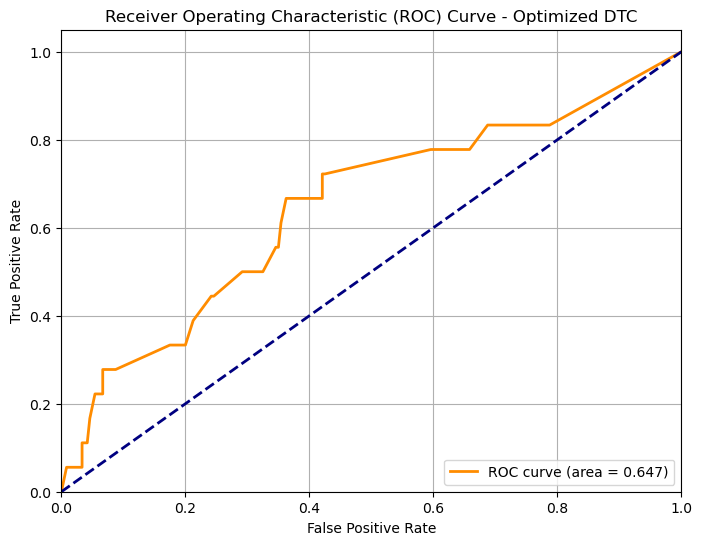

In [48]:
# Plot ROC curve for the optimized DTC model
plot_roc_curve(y_vald, dtc_best_model, "DTC")

The ROC curve is a graphical representation of a classifier's performance across different threshold values. It plots the True Positive Rate (TPR) (or recall) against the False Positive Rate (FPR).

1.**Performance:**
The ROC curve is above the diagonal line, indicating that the optimized DTC model performs better than random guessing.
However, the curve is not very close to the top-left corner, suggesting that the model's ability to distinguish between classes is moderate.

2.**AUC Score:**
The AUC score of **0.647** indicates that the model has limited discriminatory power.
While it is better than random guessing, there is significant room for improvement.

3.**Trade-off:**
The curve shows the trade-off between TPR and FPR at different thresholds.
As the threshold decreases, the model becomes more sensitive (higher TPR) but also more prone to false positives (higher FPR).

|--- nbumps3 <= 0.00
|   |--- nbumps2 <= 1.02
|   |   |--- gdpuls <= -0.47
|   |   |   |--- energy <= 0.15
|   |   |   |   |--- class: 0
|   |   |   |--- energy >  0.15
|   |   |   |   |--- gdenergy <= -0.56
|   |   |   |   |   |--- nbumps2 <= 0.98
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- nbumps2 >  0.98
|   |   |   |   |   |   |--- gdenergy <= -0.84
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- gdenergy >  -0.84
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- gdenergy >  -0.56
|   |   |   |   |   |--- class: 0
|   |   |--- gdpuls >  -0.47
|   |   |   |--- gdenergy <= 1.20
|   |   |   |   |--- nbumps <= 0.98
|   |   |   |   |   |--- maxenergy <= 0.01
|   |   |   |   |   |   |--- gdpuls <= 0.39
|   |   |   |   |   |   |   |--- gdpuls <= 0.06
|   |   |   |   |   |   |   |   |--- gdpuls <= -0.06
|   |   |   |   |   |   |   |   |   |--- gdpuls <= -0.44
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |  

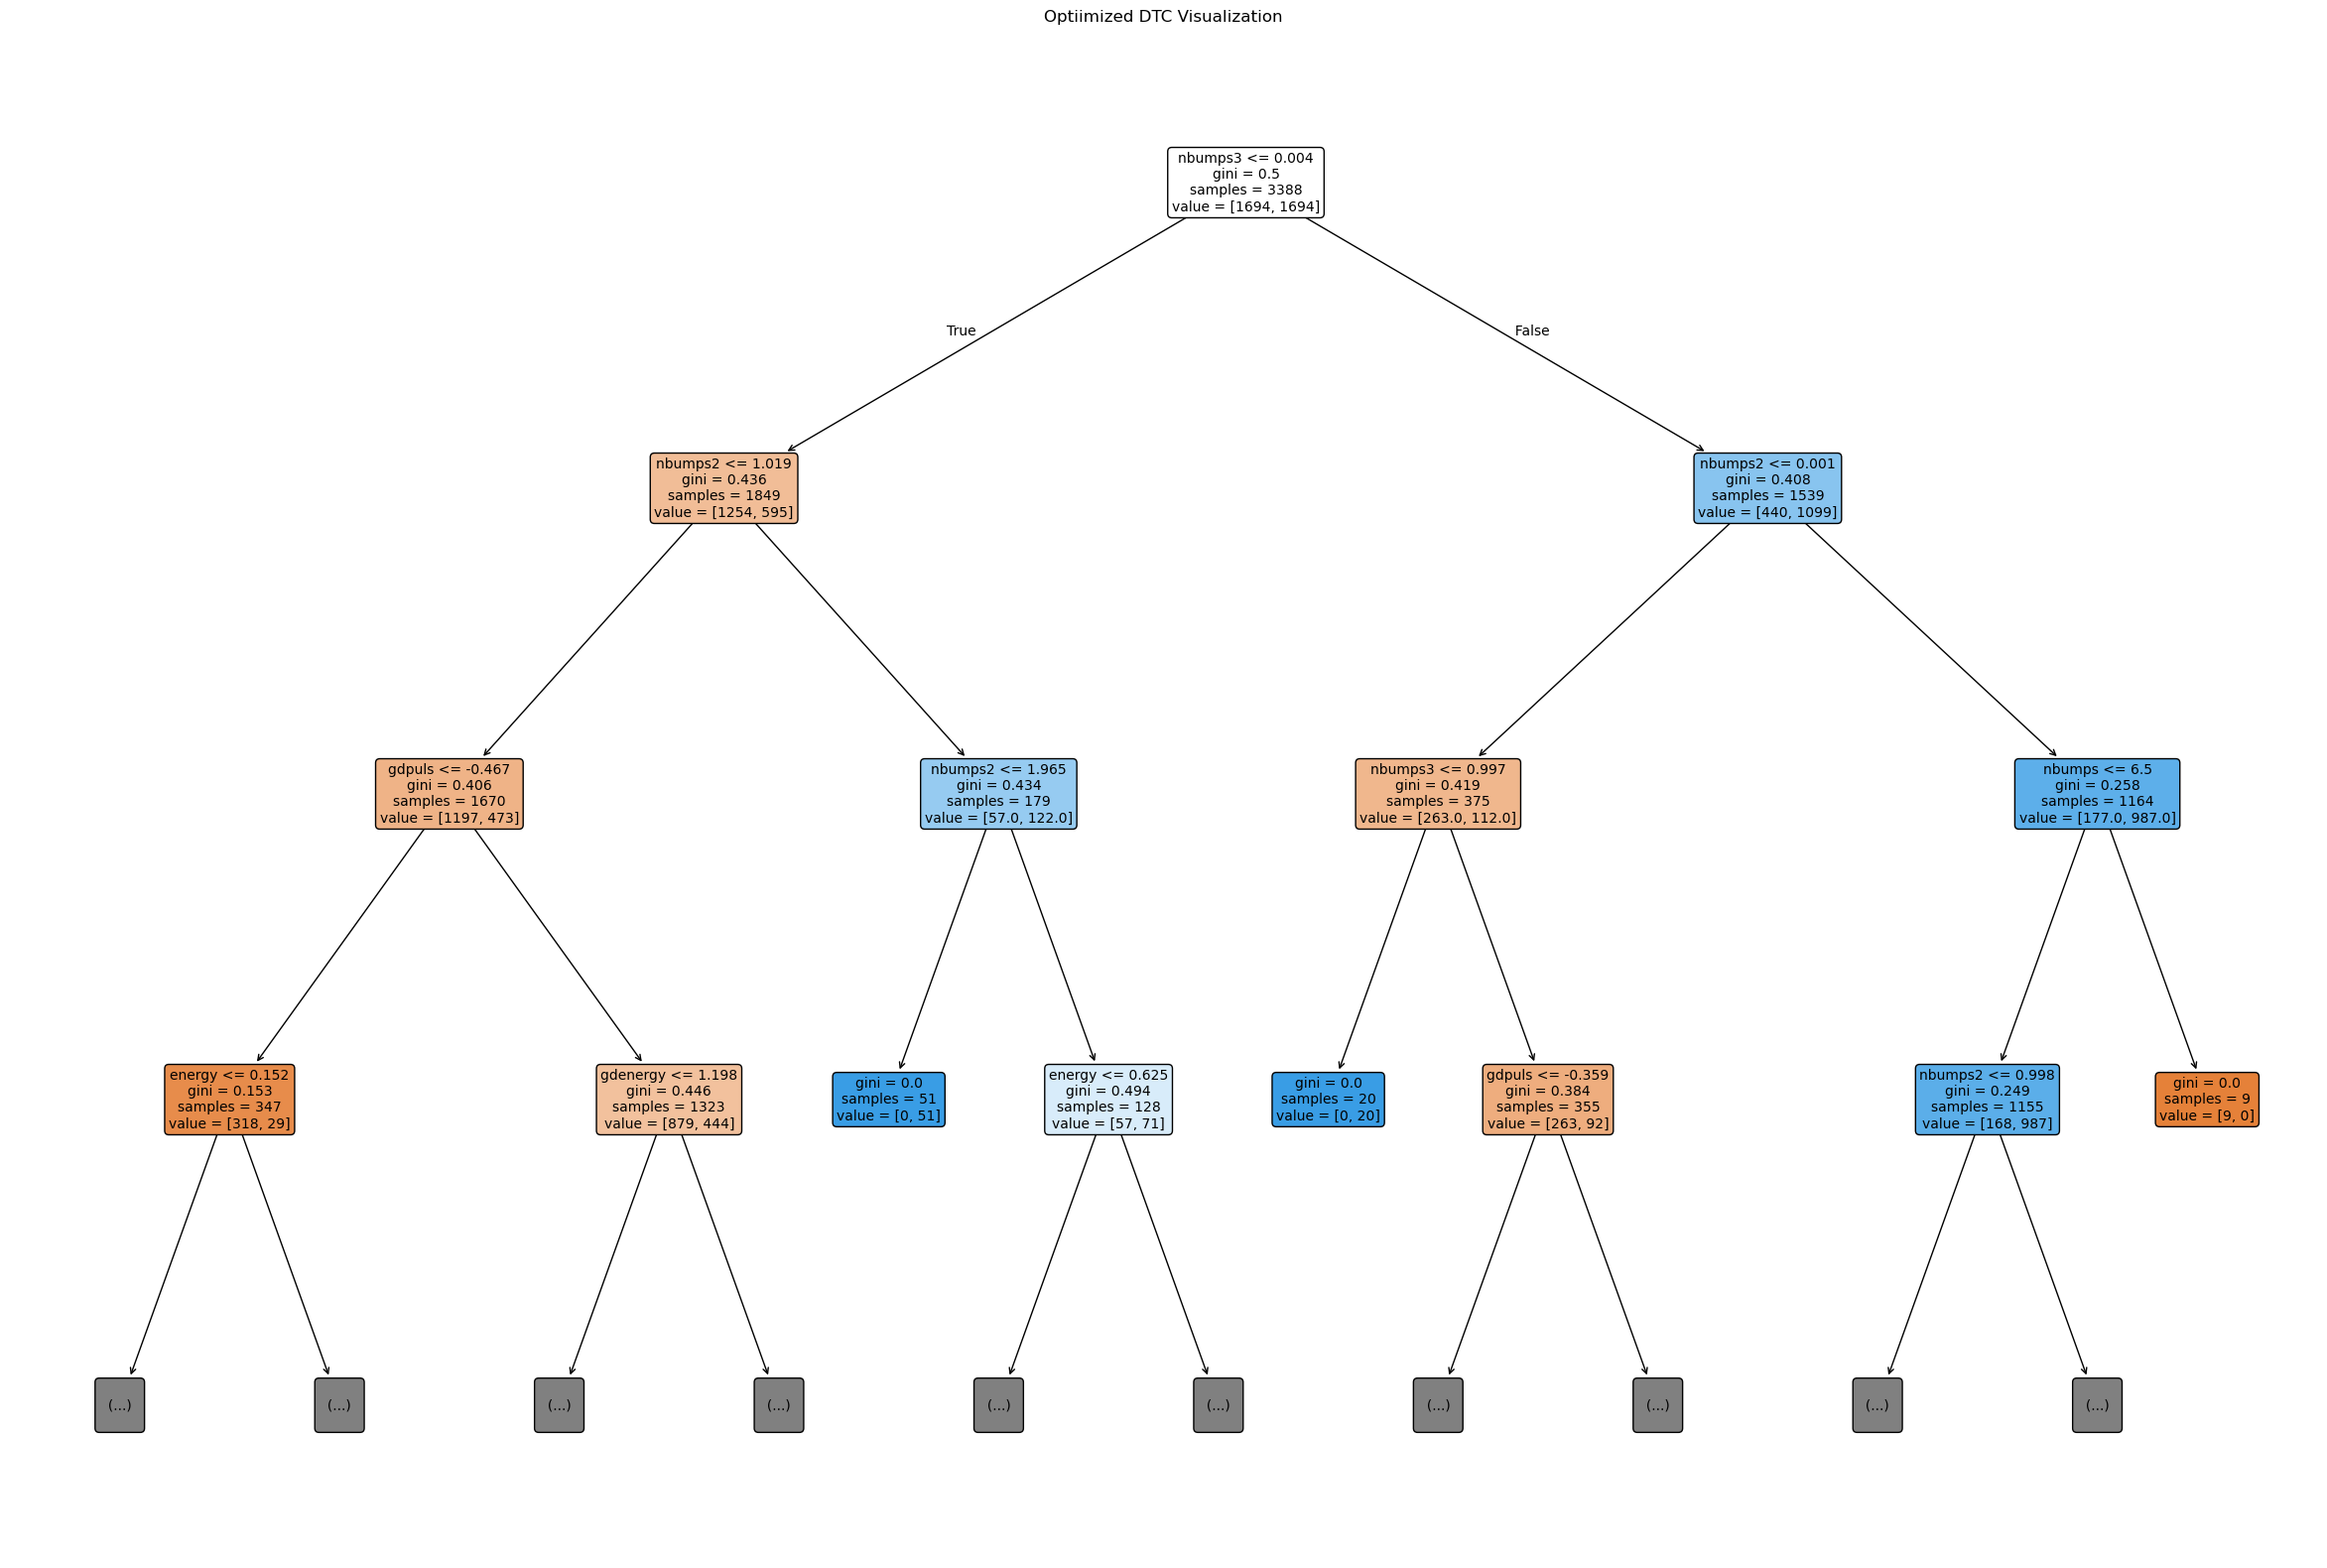

In [49]:
# Print the tree as text
print(export_text(dtc_best_model, feature_names=list(X_train_df.columns)))

# Plot the tree
plt.figure(figsize=(30, 20))
plot_tree(dtc_best_model, feature_names=list(X_train_df.columns), filled=True, rounded=True, fontsize=10, max_depth=3)
plt.title("Optiimized DTC Visualization")
plt.show()

1. The `export_text` function generates a textual representation of the decision tree, showing the hierarchical splits based on feature thresholds and the corresponding class predictions at each leaf node.

2. The `plot_tree` function creates a graphical representation of the decision tree, limited to a maximum depth of 3 for clarity.

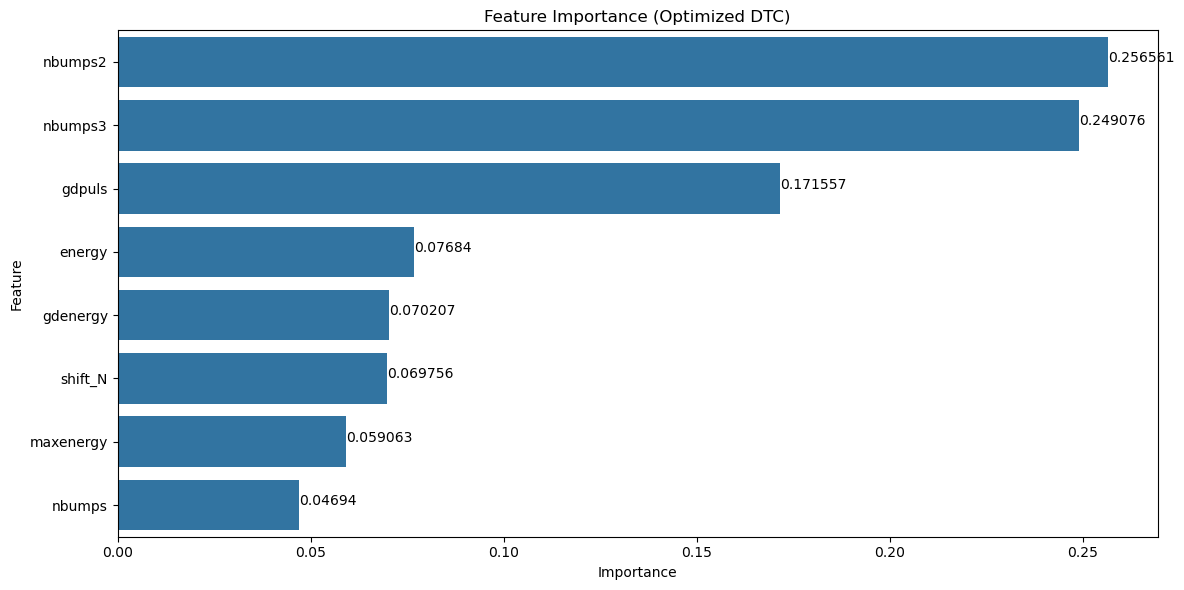

In [50]:
# Label the features with their importance scores
feature_importances = pd.DataFrame({
    "feature": selected_features,
    "importance": dtc_best_model.feature_importances_
})
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Label the bar with value
plt.figure(figsize=(12, max(6, len(feature_importances) * 0.3)))  # dynamic height
sns.barplot(x="importance", y="feature", data=feature_importances)
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, str(round(value, 6)))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Optimized DTC)")
plt.tight_layout()
plt.show()


The features importance calculates the importance scores for each selected feature and sorts them in descending order. A bar chart is then plotted to display these scores, with annotations showing the exact values for each feature.

This visualization helps identify which features contribute most to the model's decision-making process, aiding in interpretability and feature selection for future iterations.

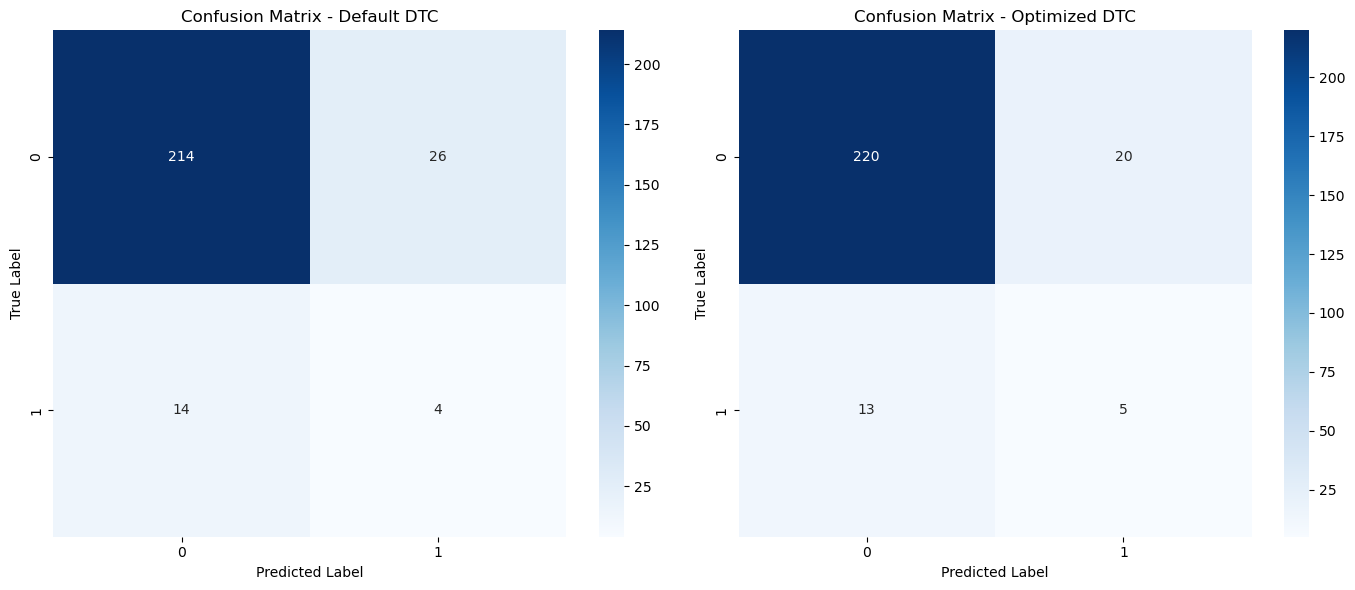

In [51]:
plot_confusion_matrices_side_by_side(y_vald, y_dtc_default_pred_val, y_dtc_best_pred_val, "DTC")

The confusion matrices for the default and optimized Decision Tree Classifier (DTC) models side by side. It highlights the differences in classification performance between the two models, showing improvement after optimized.

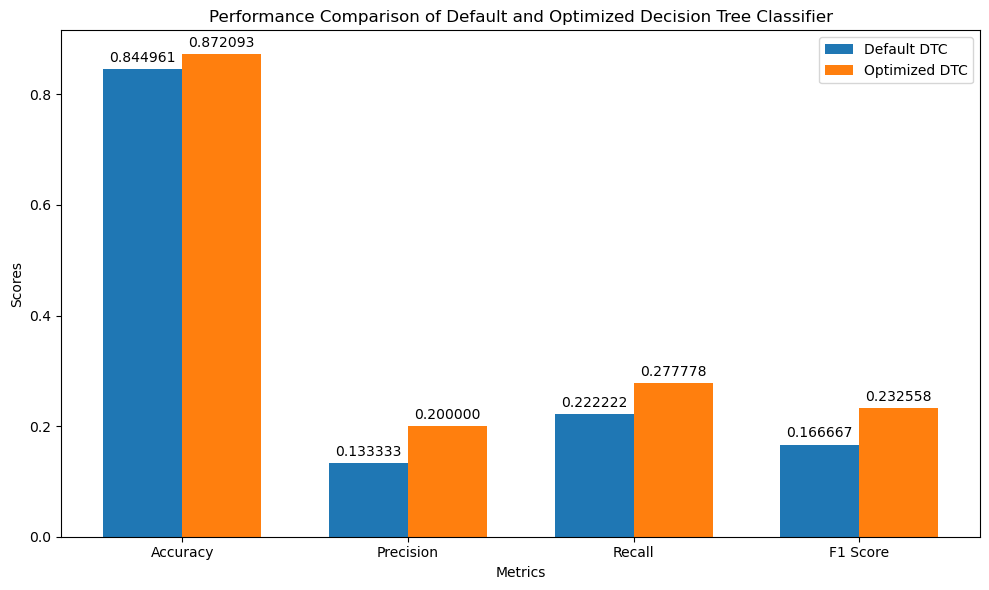

In [52]:
plot_model_comparison(y_vald, y_dtc_default_pred_val, y_dtc_best_pred_val, "Decision Tree Classifier", "DTC")

Comparison of the performance of the **default** and **optimized Decision Tree Classifier (DTC)** models using a bar chart. It evaluates four key metrics: **Accuracy**, **Precision**, **Recall**, and **F1 Score**. The optimized DTC model demonstrates improvements across all metrics, particularly in **recall** (from 0.222 to 0.278) and **F1 score** (from 0.167 to 0.233), which are critical for imbalanced datasets like seismic bump prediction. These improvements highlight the effectiveness of hyperparameter tuning in reducing false negatives and enhancing the model's sensitivity to the minority class, making it more suitable for detecting high-energy seismic events.

##### Neural Network (NN)

The **Neural Network (NN)** is a machien learning model that mimic the complex functions of the human brain. The models consist of interconnected nodes or neurons. The neurons process data, learn patterns and hence make decision.

In this project, the NN is applied to predict the occurence of high-energy seismic bumps (`class` = 1), designed using TensorFlow and Keras to create and compile a neural network model. It allows customized various hyperparameters such as the number of hidden layers, activation formulas, regularization methods, optimizer choice, and learning rate for parameter fine tuning, hence adjusting the model metric towards recall, to minimize false negative.

The model starts with an input layer, taking data of a shape defined by the `input_shape` argument. The first hidden layer has a number of neurons specified in the `hidden_layers` list. Each hidden layer uses the ReLU activation formula, L2 regularization for weight decay, and a dropout layer for regularization to prevent overfitting. The output layer is a single neuron with a sigmoid activation formula, appropriate for binary classificaiton tasks.

This model is compiled with **Binary Crossentrophy** as the loss function, which is suitable for Binary classification problems.

In summary, this function defines a fully customizable feedforward neural network with dropout and L2 regularization, suitable for bionary classification tasks, and enabling user for optimizer option customization.

**Early stopping** is used to prevent overfitting by halting training if the model performance stops improving after a certain number of epochs.

In [53]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Match validation loss
    patience=10, # Stop if no improvement after 10 epochs
    restore_best_weights=True, # Roll back to the best weights
    verbose=1 # Print messages when stopping early
)

**Learning Rate Reduction Callback**, `reduce_lr` is a callback to reduce the learning rate when the model's performance on the validation data plateaus, to help the model converge more effectively.

In [54]:
# Define learning rate reduction callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Match validation loss
    factor=0.5, # Reduce learning rate by half
    patience=5, # Wait for 5 epochs before reducing the learning rate
    min_lr=1e-6, # Minimum learning rate
    verbose=1 # Print messages when reducing the learning rate
)

To handle imbalanced dataset, **class weights** are computed to help the model give more importance to the minority class during training. While SMOTE is applied during data preprocessing to balance the dataset, this step ensures that the class weights are appropriately adjusted to further mitigate any imbalance and enhance model performance.

In [55]:
# Compute class weights from labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0, 1: 1.0}


This function, `define_model` is designed to create and compile a Keras Sequential model with the following characteristics:
- Input layer with a specified number of features.
- Hidden layers with specified units, activation functions, and dropout rates.
- Output layer with a single unit and sigmoid activation function for binary classification.

In [56]:

def define_model(
    input_shape, # shape of the input data
    hidden_layers=[36, 20, 15, 5], # number of neurons in each hidden layer
    activation='relu', # activation function for the hidden layers
    init_weights='glorot_uniform', # weight initialization method
    dropout_rate=0.2, # dropout rate for regularization
    l2_lambda=0.01, # L2 regularization parameter
    optimizer='adam', # optimizer to use for training
    learning_rate=0.001, # learning rate for the optimizer
    momentum=0.1, # momentum for SGD optimizer
):
    # Print current configuration for traceability of model parameters 
    print("Model Parameters:")
    print(f"Input shape: {input_shape}, Hidden layers: {hidden_layers}")
    print(f"Weight initialization: {init_weights}, Activation function: {activation}")
    print(f"Dropout: {dropout_rate}, L2: {l2_lambda}")
    print(f"Optimizer: {optimizer}, LR: {learning_rate}, Momentum: {momentum}\n")
    
    # Initialize the model
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_layers[0], input_shape=(input_shape,),
        activation=activation,
        kernel_regularizer=l2(l2_lambda))) # first dense layer with L2 regularization
    model.add(BatchNormalization()) # Normalize activations to improve convergence
    model.add(Dropout(dropout_rate)) # Drop neurons randomly during training to prevent overfitting
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(
            units,
            activation=activation,
            kernel_regularizer=l2(l2_lambda)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid')) # Single neuron output layer with sigmoid activation for binary classification
    
    # Optimizer
    # Create the optimizer based on the specified type
    if optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
        
    # Compile the model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=loss_fn,
        optimizer=opt,
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ]
    )
    
    return model

In [57]:
# Initliaze the model with the defined parameters
nn_default_model = define_model(input_shape=X_train.shape[1])
nn_default_model.summary()

Model Parameters:
Input shape: 8, Hidden layers: [36, 20, 15, 5]
Weight initialization: glorot_uniform, Activation function: relu
Dropout: 0.2, L2: 0.01
Optimizer: adam, LR: 0.001, Momentum: 0.1



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 36)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 36)             │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,769 (6.91 KB)

 Trainable params: 1,617 (6.32 KB)

 Non-trainable params: 152 (608.00 B)

In [58]:
# Reshape y_train and y_vald to ensure they are 2D arrays
y_train_reshape = y_train.reshape(-1, 1)
y_vald_reshape = y_vald.reshape(-1, 1)

An instance of NN with default parameters

In [59]:
# Fit the model on the training set
nn_default_history = nn_default_model.fit(
    X_train, # Training data
    y_train_reshape, # Reshaped training labels
    validation_data=(
        X_vald, # Validation features
        y_vald_reshape # Reshaped validation labels
    ), # Validation data
    epochs=100, # Set a high number of epochs to allow early stopping to take effect
    batch_size=32, # Batch size for training
    callbacks=[early_stopping, reduce_lr], # Callbacks for early stopping and learning rate reduction
    class_weight=class_weight_dict, # Use class weights to handle class imbalance
    verbose=1 # Print training progress
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.5871 - loss: 1.4447 - precision: 0.6066 - recall: 0.5032 - val_binary_accuracy: 0.7016 - val_loss: 1.2724 - val_precision: 0.1169 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6396 - loss: 1.2180 - precision: 0.6526 - recall: 0.6018 - val_binary_accuracy: 0.7171 - val_loss: 1.1466 - val_precision: 0.1233 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6512 - loss: 1.1139 - precision: 0.6651 - recall: 0.6147 - val_binary_accuracy: 0.7481 - val_loss: 1.0210 - val_precision: 0.1270 - val_recall: 0.4444 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6641 - loss: 1.0304 - precision: 0.6772 - recall: 0.6318 - val_binary_accuracy: 0.7907 - val_loss: 0.9474 - val_precision: 0.1400 - val_recall: 0.3889 - learning_rate: 0.0010
Epoc

In [60]:
# Make predictions on the validation set
print("Making predictions on the validation set...")
y_nn_default_pred_val = (nn_default_model.predict(X_vald) > 0.5).astype("int32").flatten()

# Print the default parameters of the Neural Network
print("\nDefault parameters of Neural Network: \n", nn_default_model.get_config())

# Compute F2-score
f2 = fbeta_score(y_vald.flatten(), y_nn_default_pred_val, beta=2.0)
print("\nF2-Score (β=2):", f2)

# Print the evaluation metrics for the validation set
evaluate_validation_set(y_vald, y_nn_default_pred_val)

Making predictions on the validation set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Default parameters of Neural Network: 
 {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 8), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 36, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': No

The Neural Network was trained with default parameters and evaluated on the validation set. The results showed that the model performed reasonably well on the majority class (`class = 0`), achieving a validation accuracy of 73.26%. However, the model struggled significantly with the minority class (`class = 1`), achieveing a low recall of 0.39 and a very low F1-score of 0.17. These 2 metrics are quite important especially for imbalanced dataset such as seismic data.

The confusion matrix revealed a large number of false negatives for the minority class, highlighting the model's limited sensitivity to high-energy seismic bumps. Despite achieving a moderate accuracy, the NN's performance in identifying the minority class is suboptimal, suggesting the need for hyperparameter tuning and potential adjustments to handle the class imbalance more effectively.

Hyperparameter tuning using GridSearchCV for Neural Network

In [61]:
# Initialize the KerasClassifier with fit-compatible parameters
nn = KerasClassifier(
    build_fn=define_model,
    input_shape=X_train.shape[1],
    
    # Define the model parameters
    hidden_layers=[36, 20, 15, 5],
    activation='relu',
    init_weights='glorot_uniform',
    dropout_rate=0.2,
    l2_lambda=0.01,
    optimizer='adam',
    learning_rate=0.001,
    momentum=0.1,
    
    # Define the training parameters
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    
    verbose=0 # Set verbose to 0 to suppress output during fitting
)

In [ ]:
# Set the hyperparameter grid for the Neural Network
nn_param_grid = {
    'hidden_layers': [[36, 20, 15, 5], [64, 32, 16], [128, 64, 32]],  # Different configurations of hidden layers
    'activation': ['relu', 'tanh'],  # Activation functions for the hidden layers
    'init_weights': ['glorot_uniform', 'he_uniform'],  # Weight initialization methods
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rates for regularization
    'l2_lambda': [0.01, 0.001],  # L2 regularization parameters
    'optimizer': ['adam', 'sgd', 'rmsprop'],  # Optimizers
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],  # Learning rates for the optimizers
    'momentum': [0.1, 0.9],  # Momentum for SGD optimizer
    'epochs': [50, 100, 150, 200],  # Number of epochs for training
    'batch_size': [32, 64, 128, 256, 512]  # Batch size for training
}

# Set up GridSearchCV
nn_grid_search = RandomizedSearchCV(
    estimator=nn,
    param_distributions=nn_param_grid,
    scoring="recall", # Choose to refit the base model based on recall score due to class imbalance
    cv=cv, # 5-fold cross-validation with 3 repeats
    verbose=1, # Verbose output 1 to see the progress
    n_jobs=-1, # Use all available cores to speed up the process
    error_score=0, # Set error score to 0 for any failed configurations
    n_iter=10, # Number of iterations for RandomizedSearchCV
    
    random_state=seed_num, # Set random state for reproducibility
)

# Fit the grid search to training data
nn_grid_results = nn_grid_search.fit(X_train, y_train_reshape)

Fitting 25 folds for each of 10 candidates, totalling 250 fits
Model Parameters:
Input shape: 8, Hidden layers: [128, 64, 32]
Weight initialization: he_uniform, Activation function: relu
Dropout: 0.1, L2: 0.001
Optimizer: adam, LR: 1e-05, Momentum: 0.1



In [73]:
# Output best hyperparameters and best cross-validation score
print(f"✅ Best hyperparameters found: {nn_grid_results.best_params_}")
print(f"✅ Best cross-validation score: {nn_grid_results.best_score_:.6f}")

# Get the best model
nn_best_model = nn_grid_results.best_estimator_

# Make predictions on the validation set
y_nn_best_pred_val = nn_best_model.predict(X_vald)

# Print the evaluation metrics for the validation set
evaluate_validation_set(y_vald, y_nn_best_pred_val)

✅ Best hyperparameters found: {'optimizer': 'rmsprop', 'momentum': 0.1, 'learning_rate': 1e-05, 'l2_lambda': 0.001, 'init_weights': 'he_uniform', 'hidden_layers': [128, 64, 32], 'epochs': 150, 'dropout_rate': 0.1, 'batch_size': 32, 'activation': 'relu'}
✅ Best cross-validation score: 0.881107


📊 Evaluation metrics for validation set:
Validation set accuracy: 0.709302
Validation set precision: 0.120000
Validation set recall: 0.500000
Validation set f1 score: 0.193548

Validation set confusion matrix: 
 [[174  66]
 [  9   9]]

Validation set classification report: 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82       240
           1       0.12      0.50      0.19        18

    accuracy                           0.71       258
   macro avg       0.54      0.61      0.51       258
weighted avg       0.89      0.71      0.78       258



The Neural Network (NN) underwent hyperparameter tuning using `RandomizedSearchCV`, where it randomly samples from a predefined search space of hyperpameters to balance the time, computational resources, and the likelihood of finding an optimal model configuration while the search space is extremely large.

It optimizes recall to detect more high-energy seismic bumps and reduce the missed alarm rate. The best model achieved by adjusting its parameters such as `activation` and `batch_size`.

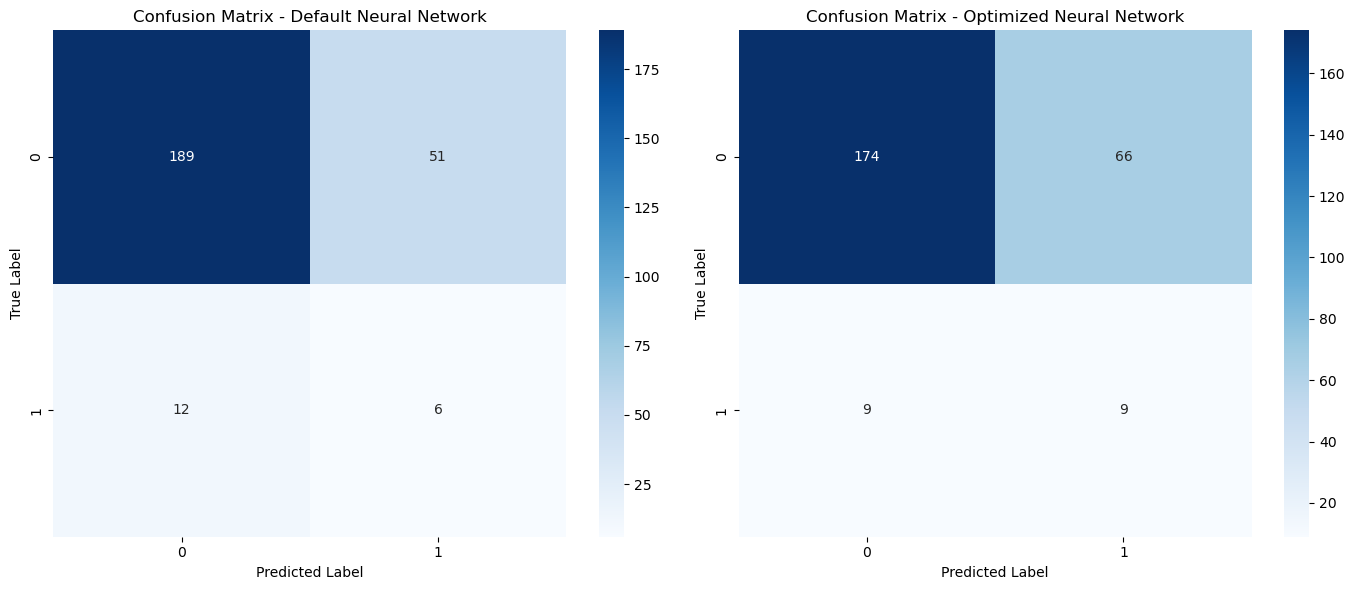

In [64]:
plot_confusion_matrices_side_by_side(y_vald, y_nn_default_pred_val, y_nn_best_pred_val, "Neural Network")

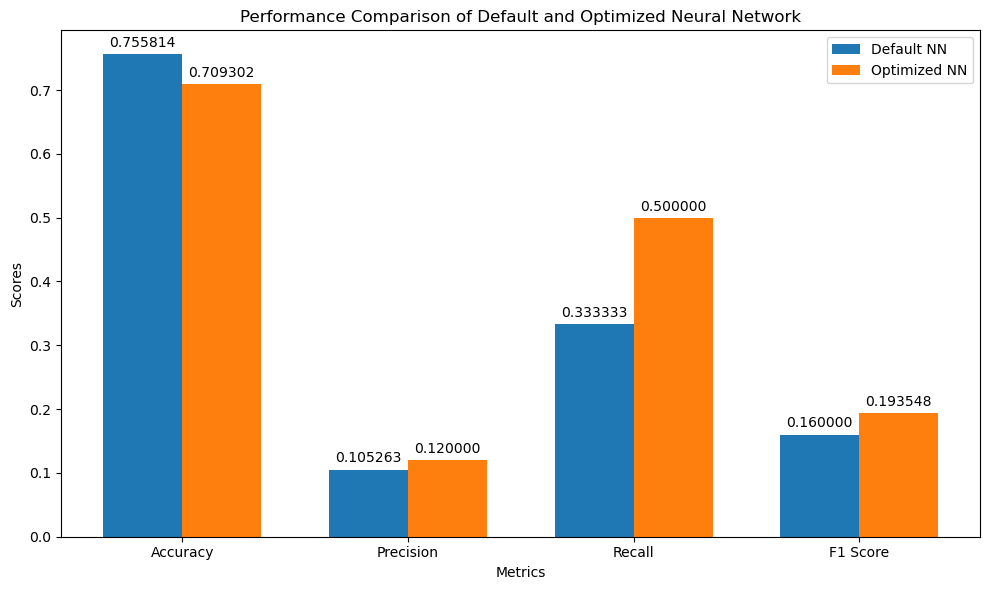

In [65]:
plot_model_comparison(y_vald, y_nn_default_pred_val, y_nn_best_pred_val, "Neural Network", "NN")

#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________


In [66]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate a model using multiple metrics (weighted and macro)
    """
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Weighted F1 Score': f1_score(y_true, y_pred, average='weighted'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro F1 Score': f1_score(y_true, y_pred, average='macro')
    }
    return metrics

In [67]:
def compare_models(y_true, model1_pred, model2_pred,
                   model1_name, model2_name):
    """
    Compare three models using various metrics
    """
    # Calculate metrics for each model
    metrics1 = evaluate_model(y_true, model1_pred, model1_name)
    metrics2 = evaluate_model(y_true, model2_pred, model2_name)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame([metrics1, metrics2])

    cm_model1 = confusion_matrix(y_true, model1_pred)
    cm_model2 = confusion_matrix(y_true, model2_pred)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Confusion matrix for model 1
    sns.heatmap(cm_model1, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - Optimized ' + model1_name)
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Confusion matrix for model 2
    sns.heatmap(cm_model2, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - Optimized ' + model2_name)
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()
    
    # Plot comparison bar chart - Accuracy, Weighted Precision, Weighted Recall, Weighted F1 Score
    metrics_to_plot = ['Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F1 Score']
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    bars1 = plt.bar(x - width, comparison_df[metrics_to_plot].iloc[0], width, label=model1_name)
    bars2 = plt.bar(x, comparison_df[metrics_to_plot].iloc[1], width, label=model2_name)

    # Annotate bars with their values
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison (Weighted Avg)')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.show()

    # Plot comparison bar chart - Accuracy, Macro Precision, Macro Recall, Macro F1 Score
    metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score']
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_to_plot))
    width = 0.25
    
    bars1 = plt.bar(x - width, comparison_df[metrics_to_plot].iloc[0], width, label=model1_name)
    bars2 = plt.bar(x, comparison_df[metrics_to_plot].iloc[1], width, label=model2_name)

    # Annotate bars with their values
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison (Macro Avg)')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    plt.show()
    
    # Print detailed classification reports
    print(f"\nClassification Report for {model1_name}:")
    print(classification_report(y_true, model1_pred))
    print(f"\nClassification Report for {model2_name}:")
    print(classification_report(y_true, model2_pred))
    
    return comparison_df

##### Decision Tree Classifier (DTC)

In [ ]:
# Predict on the test set using the best Decision Tree model
y_pred_dtc = dtc_best_model.predict(X_test)

##### Neural Network (NN)

In [ ]:
# Predict on the test set using the best Neural Network model
y_pred_nn = nn_best_model.predict(X_test)

#### Model Comparison

In [ ]:
# Convert predictions to binary labels
y_pred_nn_labels = (y_pred_nn > 0.5).astype(int)

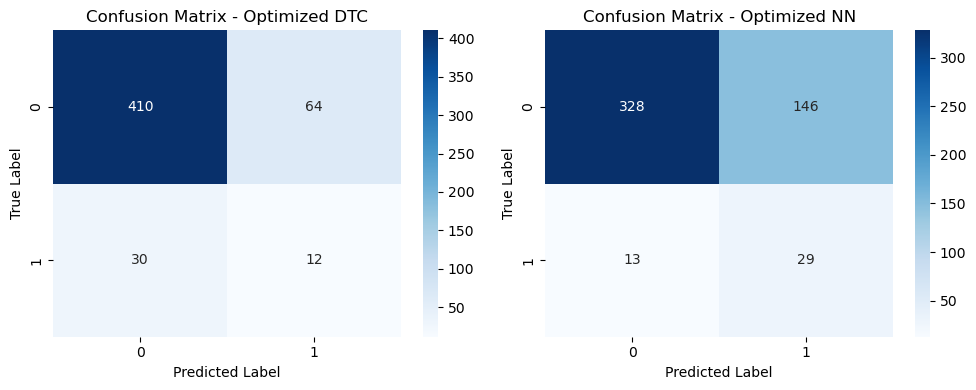

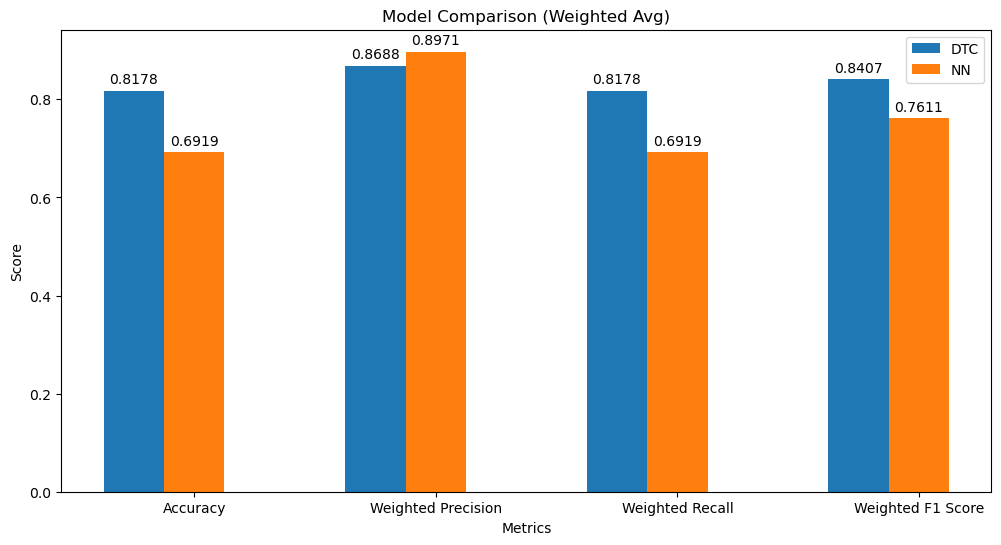

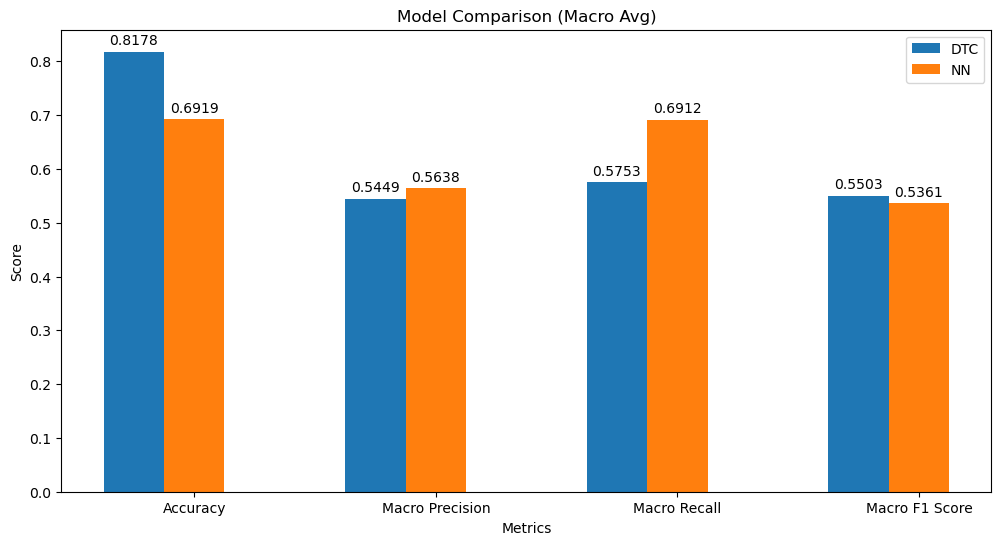


Classification Report for DTC:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       474
           1       0.16      0.29      0.20        42

    accuracy                           0.82       516
   macro avg       0.54      0.58      0.55       516
weighted avg       0.87      0.82      0.84       516


Classification Report for NN:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       474
           1       0.17      0.69      0.27        42

    accuracy                           0.69       516
   macro avg       0.56      0.69      0.54       516
weighted avg       0.90      0.69      0.76       516



In [ ]:
# Compare the models on the test set
results = compare_models(
    y_test,
    y_pred_dtc,
    y_pred_nn_labels,
    model1_name="DTC",
    model2_name="NN"
    )

In [72]:
# Print detailed results
print("\nDetailed Model Comparison:")
print(results.to_string(index=False))


Detailed Model Comparison:
Model  Accuracy  Weighted Precision  Weighted Recall  Weighted F1 Score  Macro Precision  Macro Recall  Macro F1 Score
  DTC  0.817829            0.868824         0.817829           0.840686         0.544856      0.575347        0.550273
   NN  0.691860            0.897073         0.691860           0.761148         0.563796      0.691230        0.536095


#### **Model Evaluation Description:**
The **model evaluation** compares the performance of two optimized classifiers: **Decision Tree Classifier (DTC)**, and **Neural Network (NN)**. The evaluation focuses on key metrics such as **accuracy**, **precision**, **recall**, and **F1-score**, with a particular emphasis on **recall** due to the imbalanced nature of the dataset. The goal is to identify the model best suited for detecting high-energy seismic bumps (class 1), where minimizing false negatives is critical.

##### **Key Observations:**

1. **Confusion Matrices:**

    - **DTC:** Achieved strong performance on class 0 with 410 true negatives and moderate sensitivity to class 1, correctly predicting 12 positives and missing 30 (false negatives). This indicates that the DTC has a good balance but struggles with the minority class (`class = 1`)

    - **NN:** Showed **high recall for class 1** (29 true positives out of 42), demonstrating a strong sensitivity to the minority class. However, it misclassified 146 class 0 instances as positives, resulting in a higher number of false positives compared to DTC. Despite this, NN showed a better ability to detect the minority class, making it more suitable for scenarios that prioritize reducing false negatives, such as minimizing missed alarms in seismic bump detection.

2. **Bar Charts – Performance Metrics:**

    - **Weighted Metrics:**

        - **DTC** ranked higher in accuracy (0.8178), weighted recall (0.8178), and weighted F1-score (0.8407).

        - **NN** achieved higher weighted precision (0.8971) than DTC, but had a lower weighted recall (0.6919) and weighted F1-score (0.7611), showing a trade-off between precision and recall.

    - **Macro Metrics:**

        - NN had higher macro recall (0.6912), demonstrating its better sensitivity to the minority class compared to DTC.

        - NN showed a slightly higher macro precision (0.5638) compared to DTC, reflecting its ability to correctly classify class 0 instances, but its macro F1-score (0.5361) was slightly lower than DTC's.

3. **Classification Reports:**

    - **DTC**: Delivered the most balanced report with good precision and recall for class 0, but moderate performance for class 1 (recall = 0.29). While DTC achieves high performance in detecting class 0 (majority class), it struggles with detecting class 1, making it less suitable for imbalanced datasets where detecting the minority class is critical.

    - **NN**: Exhibited strong recall for class 1 (0.69), indicating its ability to identify high-energy seismic bumps effectively. While its precision (0.17) remains low, the model's recall performance is critical in minimizing false negatives, which is essential in safety-critical applications. It performs better at balancing the recall between both classes (both classes 0.69), particularly showing a significant improvement in recall for class 1. This makes NN a better choice when minimizing false negatives (missed alarms) for seismic bumps is a priority.



##### **Conclusion**: 

**Neural Network (NN)** was chosen as the optimal model for this task due to its **superior recall for detecting high-energy seismic bumps**, which is crucial for reducing false negatives in safety-critical domains. Despite a lower precision score, NN's ability to identify the minority class more effectively makes it the better choice over the Decision Tree Classifier (DTC). DTC, while providing a good balance overall, failed to detect class 1 as reliably as NN. DTC achieved:

- **Higher Macro Recall (0.6912)**, indicating better sensitivity to the minority class.

- **Higher Weighted Precision (0.8971)**, showing its effective classification of class 0 instances.

- **Higher Macro Precision (0.5638)**, reflecting a better overall precision balance between both classes.

- **Balanced class performance** across precision, recall, and f1-score for both classes.

In summary, NN stands out as the **most optimized model**, offering a **strong trade-off between recall, accuracy and general classification performance**, while still maintaining good interpretability and practical applicability for seismic bump prediction and reducing missed alarms.